## AIM: Train a multiclass classification model for predicting the psychiatric diagnosis based on EEG features

THIS VERSION INCLUDES BIG MISTAKE BECAUSE THE FEATURE SETS WITH NO SKEW/KURT WERE CREATED WITH THE WRONG DATAFRAME (FOR EXAMPLE FOR df_features_ec_nosk SHOULD BE df_features_ec), RESULTS FOR MODELS TRAINED WITH FULL FEATURE SET IS STILL CORRECT

SVC, RanFor & GradientBoostingClassifier for predicting psychiatric diagnosis with statistical features of the power per frequency band per channel group (frontal, central, parietal, occipital). Statistical features are calculated with EC data, EO data and a with the ratio between EC divided by EO.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import mne
import os
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_multitaper

%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

### Loading in feature data

In [2]:
df_features = pd.read_pickle('df_stat_features.pkl')
df_features['age'] = df_features['age'].round().astype('Int32') # round age to nearest year and convert to int
df_features = df_features.dropna(subset=['diagnosis'])
df_features.sample(7)

ID   age  gender diagnosis  epoch  EO_frontal_delta_std  \
5056  sub-88050529    12     1.0      ADHD      5              0.331081   
991   sub-87971197    71     0.0       SMC      8              0.370037   
2767  sub-88025917    15     1.0      ADHD      8              0.393351   
4685  sub-88046981    39     1.0       MDD      6              0.340804   
1857  sub-88013089     8     1.0      ADHD     10              0.427455   
853   sub-87970345    61     0.0       SMC      2              0.378564   
1241  sub-87980197  <NA>     0.0   HEALTHY      6              0.374554   

      EO_frontal_delta_mean  EO_frontal_delta_median  EO_frontal_delta_skew  \
5056              -0.110667                -0.105668              -0.676148   
991               -0.143403                -0.129451              -0.431434   
2767              -0.159180                -0.157900              -0.382516   
4685              -0.120187                -0.115899              -0.423251   
1857              -0.191936                -0.183667              -0.293352   
853               -0.145543                -0.141593              -0.466989   
1241              -0.144315                -0.142954              -0.460167   

      EO_frontal_delta_kurt  ...  ratio_parietal_gamma_std  \
5056               0.722509  ...                  0.959516   
991                0.146574  ...                  0.991220   
2767               0.201741  ...                  1.084272   
4685               0.203621  ...                  0.963121   
1857               0.001921  ...                  1.029589   
853                0.248243  ...                  1.142488   
1241              -0.000385  ...                  0.989963   

      ratio_parietal_gamma_mean  ratio_parietal_gamma_median  \
5056                   0.939969                     0.880715   
991                    0.989386                     1.101342   
2767                   1.206538                     1.216674   
4685                   0.952683                     0.906452   
1857                   1.039671                     1.058509   
853                    1.343698                     1.372843   
1241                   0.963278                     0.893075   

      ratio_parietal_gamma_skew  ratio_parietal_gamma_kurt  \
5056                   0.854677                   0.728910   
991                    0.855703                   0.779337   
2767                   0.656226                   0.674027   
4685                   0.860684                   0.761394   
1857                   1.166133                   1.197949   
853                    0.696896                   0.149637   
1241                   1.334116                   2.319481   

      ratio_occipital_gamma_std  ratio_occipital_gamma_mean  \
5056                   1.043308                    1.059905   
991                    1.032242                    1.061650   
2767                   1.064576                    1.153959   
4685                   1.017029                    1.045007   
1857                   1.041743                    1.053986   
853                    1.102074                    1.228932   
1241                   0.972155                    0.900047   

      ratio_occipital_gamma_median  ratio_occipital_gamma_skew  \
5056                      1.018522                    1.264203   
991                       1.018015                    1.134722   
2767                      1.153594                    0.715467   
4685                      0.967653                    0.816591   
1857                      1.005160                    1.332885   
853                       1.243175                    0.848649   
1241                      0.892341                    1.552324   

      ratio_occipital_gamma_kurt  
5056                    3.333790  
991                     0.394794  
2767                    0.452976  
4685                    0.434051  
1857                    1.464084  
853                     1.25011

In [3]:
df_features['diagnosis'].value_counts()

diagnosis
MDD        3732
ADHD       2051
SMC        1032
HEALTHY     564
OCD         540
Name: count, dtype: int64

In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_features_ec = df_features[df_features.columns[~(df_features.columns.str.startswith('EO') | df_features.columns.str.startswith('ratio'))]]
df_features_eo = df_features[df_features.columns[~(df_features.columns.str.startswith('EC') | df_features.columns.str.startswith('ratio'))]]
df_features_ratio = df_features[df_features.columns[~(df_features.columns.str.startswith('EC') | df_features.columns.str.startswith('EO'))]]

In [5]:
# channel groupings
frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4']
central = ['T7', 'C3', 'Cz', 'C4', 'T8']
parietal = ['CP3','CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8'] 
occipital = ['O1', 'Oz', 'O2']
channel_groups = {'frontal': frontal, 'central': central, 'parietal': parietal, 'occipital': occipital}

# define (5) frequencies of interest for TFR per frequency band
delta = np.array([1, 1.5, 2, 2.5, 3]) # starting at one because of high-pass filter
theta = np.array([4, 4.75, 5.5, 6.25, 7])
alpha = np.array([8, 9, 10, 11, 12])
beta = np.array([13, 17.25, 21.5, 25.75, 30])
gamma = np.array([42, 54, 66, 78, 90]) 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}

# Training models (SVC, RF, GBC):
Each model is tuned & trained with the full 'ratio', 'ec', and 'eo' feature sets, and trained with the 'ratio', 'ec', and 'eo' feature sets without kurtosis & skewness
All models are tuned, trained & evaluated using nested cv (inner=3, outer=5), with SVC using GridSearchCV for tuning, and RF & GBC first using RandomizedSearchCV before GridSearchCV for tuning.
The RandomizedSearchCV used the inner cv on the full dataset, not sure if that is completely correct.

## SVC

#### ratio feature set

In [6]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['ratio']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ratio[numeric_cols + cat_cols]
Y = df_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# hyperparameter ranges for GridSearch
param_grid = {
'rbf_svm__estimator__C': [0.01, 0.1, 1, 10, 100],
'rbf_svm__estimator__gamma': [0.1, 1, 10, 100],
'rbf_svm__estimator__kernel': ['rbf'],
'rbf_svm__estimator__class_weight': ['balanced']
}

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(class_weight = 'balanced')))]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

# define gridsearch
gridsearch = GridSearchCV(pipeline,
                        param_grid = param_grid,
                        cv = cv_inner, # use inner cv for hyperparameter tuning
                        scoring = f1_scorer,
                        error_score = 'raise',
                        return_train_score = True,
                        n_jobs=-1,
                        verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
gridsearch_fit = gridsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {gridsearch_fit.best_params_}')
print(f'Best f1-score: {gridsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
svm_test_score = cross_val_score(gridsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 fit_params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('SVM test scores:', svm_test_score)
print('Mean SVM test score:', np.mean(svm_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}
Best f1-score: 0.3725472398820269


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVM test scores: [0.36008559 0.37375283 0.3758282  0.37242108 0.38779348]
Mean SVM test score: 0.37397623779178135


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


In [ ]:
# final pipeline
best_params = {}
for hyperparameter in gridsearch.best_params_:
    key = hyperparameter[20:]
    best_params[key] = gridsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    Y_one_hot,
    Y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

In [ ]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EC feature set

In [43]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EC']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ec[numeric_cols + cat_cols]
Y = df_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# hyperparameter ranges for GridSearch
param_grid = {
'rbf_svm__estimator__C': [0.01, 0.1, 1, 10, 100],
'rbf_svm__estimator__gamma': [0.1, 1, 10, 100],
'rbf_svm__estimator__kernel': ['rbf'],
'rbf_svm__estimator__class_weight': ['balanced']
}

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(class_weight = 'balanced')))]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

# define gridsearch
gridsearch = GridSearchCV(pipeline,
                        param_grid = param_grid,
                        cv = cv_inner, # use inner cv for hyperparameter tuning
                        scoring = f1_scorer,
                        error_score = 'raise',
                        return_train_score = True,
                        n_jobs=-1,
                        verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
gridsearch_fit = gridsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {gridsearch_fit.best_params_}')
print(f'Best f1-score: {gridsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
svm_test_score = cross_val_score(gridsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 fit_params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('SVM test scores:', svm_test_score)
print('Mean SVM test score:', np.mean(svm_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}
Best f1-score: 0.33727880460069853


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


SVM test scores: [0.34987304 0.34467294 0.34456404 0.33989765 0.35343078]
Mean SVM test score: 0.3464876893612381


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.5min finished


{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


f1_score: 0.3461732108772494

classification report:
               precision    recall  f1-score   support

        ADHD       0.52      0.10      0.17      2051
     HEALTHY       0.00      0.00      0.00       564
         MDD       0.48      0.97      0.64      3732
         OCD       0.00      0.00      0.00       540
         SMC       0.00      0.00      0.00      1032

    accuracy                           0.48      7919
   macro avg       0.20      0.21      0.16      7919
weighted avg       0.36      0.48      0.35      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


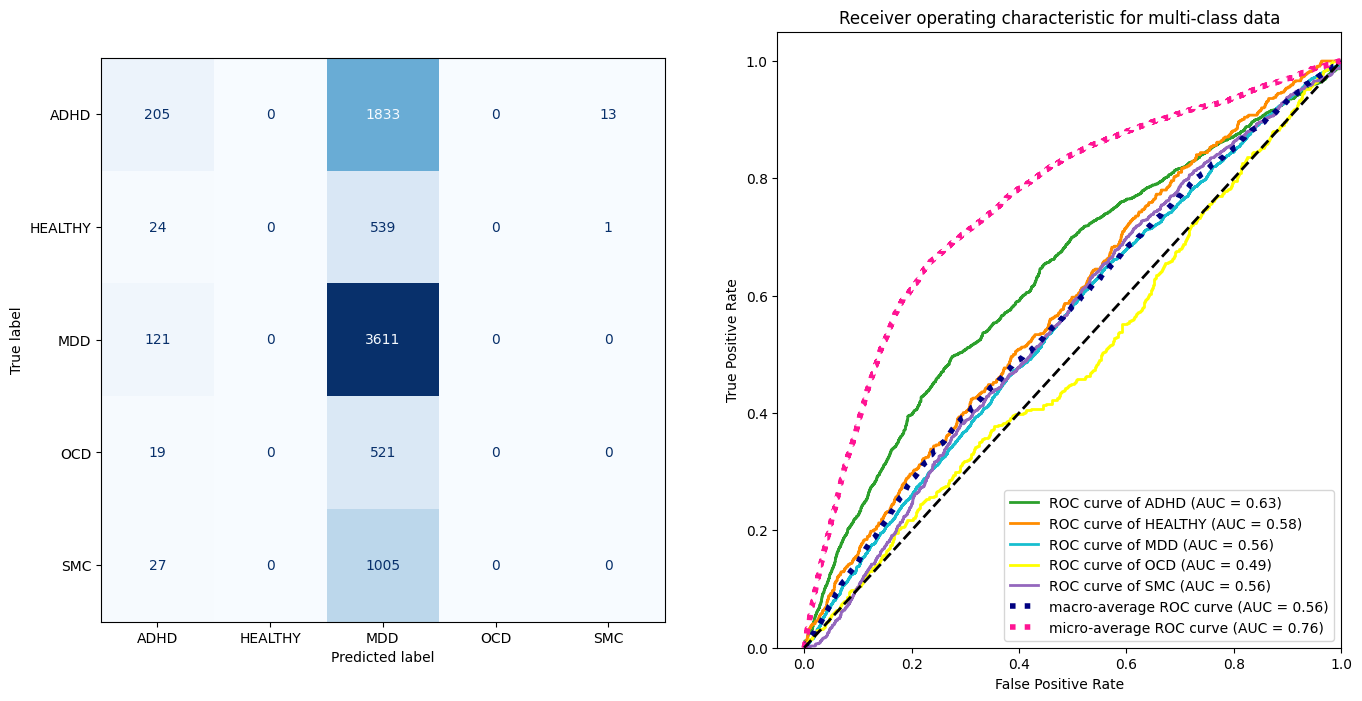

In [44]:
# final pipeline
best_params = {}
for hyperparameter in gridsearch.best_params_:
    key = hyperparameter[20:]
    best_params[key] = gridsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 101), X_test.shape = (1980, 101), Y_train.shape = (5939,), Y_test.shape = (1980,)


Text(0.5, 1.0, 'Difference between training - testing data')

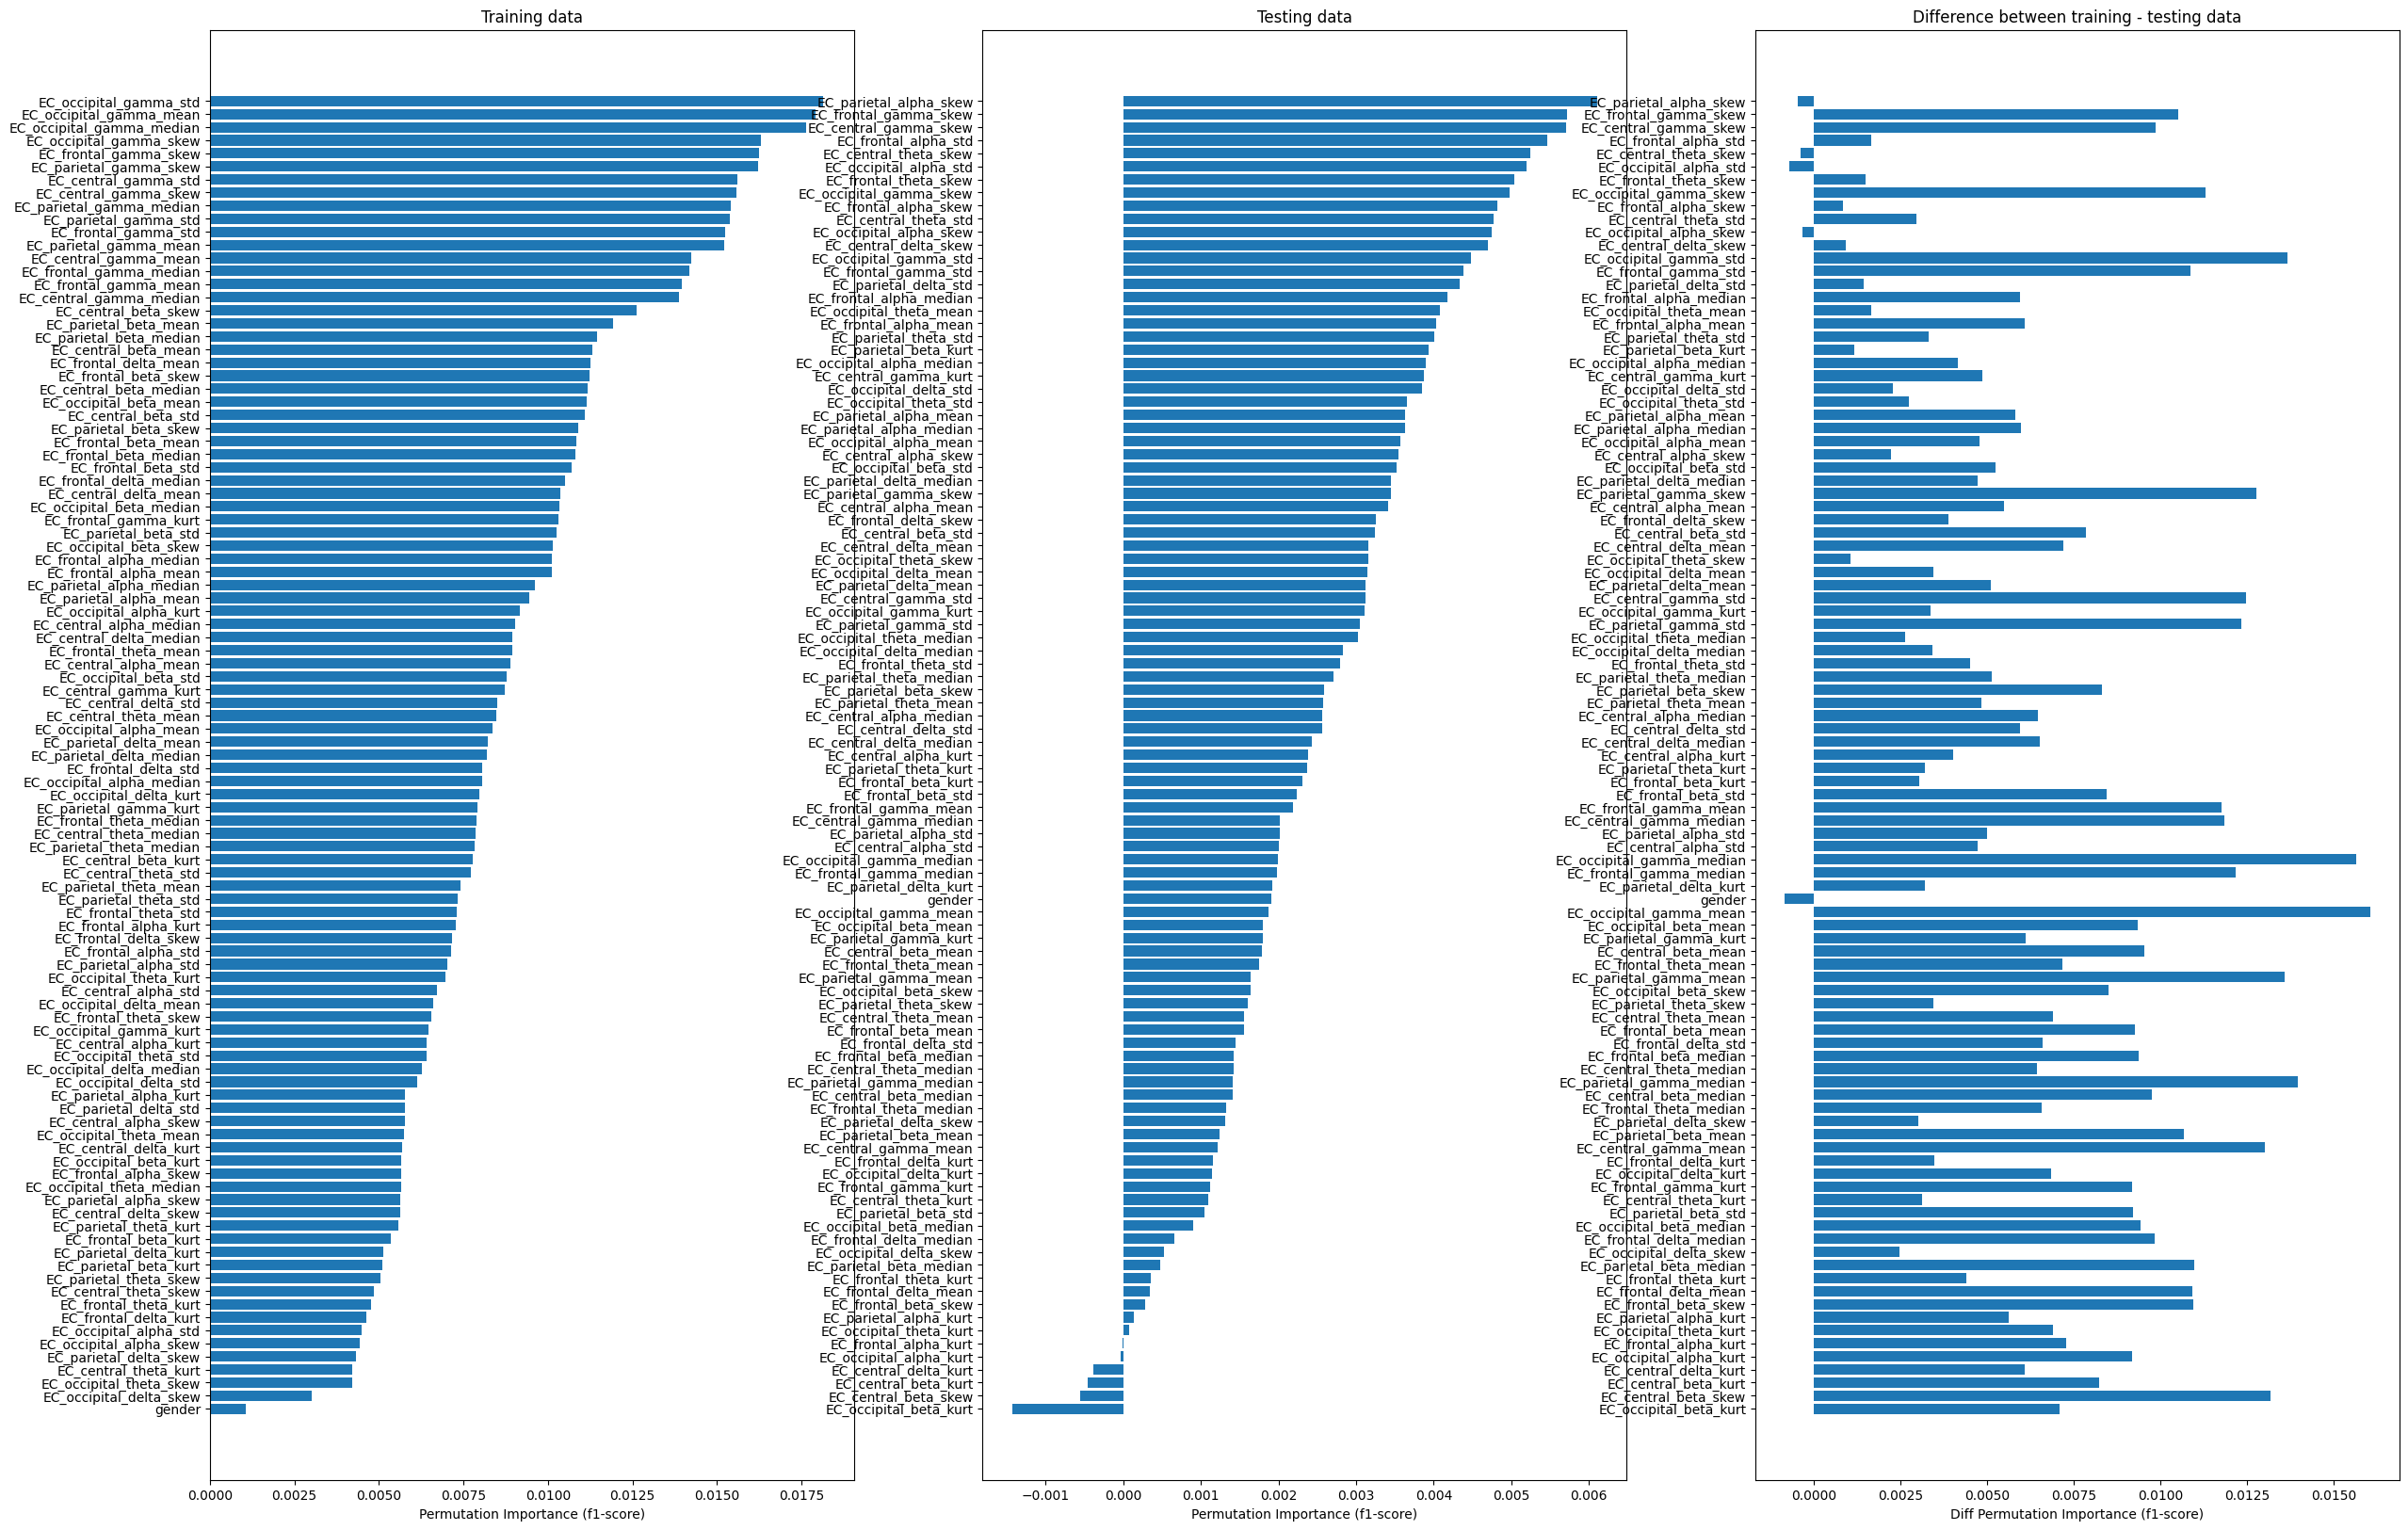

In [45]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EO feature set

In [46]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_eo[numeric_cols + cat_cols]
Y = df_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# hyperparameter ranges for GridSearch
param_grid = {
'rbf_svm__estimator__C': [0.01, 0.1, 1, 10, 100],
'rbf_svm__estimator__gamma': [0.1, 1, 10, 100],
'rbf_svm__estimator__kernel': ['rbf'],
'rbf_svm__estimator__class_weight': ['balanced']
}

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(class_weight = 'balanced')))]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

# define gridsearch
gridsearch = GridSearchCV(pipeline,
                        param_grid = param_grid,
                        cv = cv_inner, # use inner cv for hyperparameter tuning
                        scoring = f1_scorer,
                        error_score = 'raise',
                        return_train_score = True,
                        n_jobs=-1,
                        verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
gridsearch_fit = gridsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {gridsearch_fit.best_params_}')
print(f'Best f1-score: {gridsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
svm_test_score = cross_val_score(gridsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 fit_params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('SVM test scores:', svm_test_score)
print('Mean SVM test score:', np.mean(svm_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1086: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1086: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Best parameters: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}
Best f1-score: 0.33975253388672977


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVM test scores: [0.35073812 0.35195344 0.3550366  0.33731644 0.33913186]
Mean SVM test score: 0.3468352920647263


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.6min finished


{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


f1_score: 0.34684893108534126

classification report:
               precision    recall  f1-score   support

        ADHD       0.50      0.11      0.17      2051
     HEALTHY       0.33      0.00      0.00       564
         MDD       0.48      0.96      0.64      3732
         OCD       0.00      0.00      0.00       540
         SMC       0.20      0.00      0.01      1032

    accuracy                           0.48      7919
   macro avg       0.30      0.21      0.16      7919
weighted avg       0.40      0.48      0.35      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


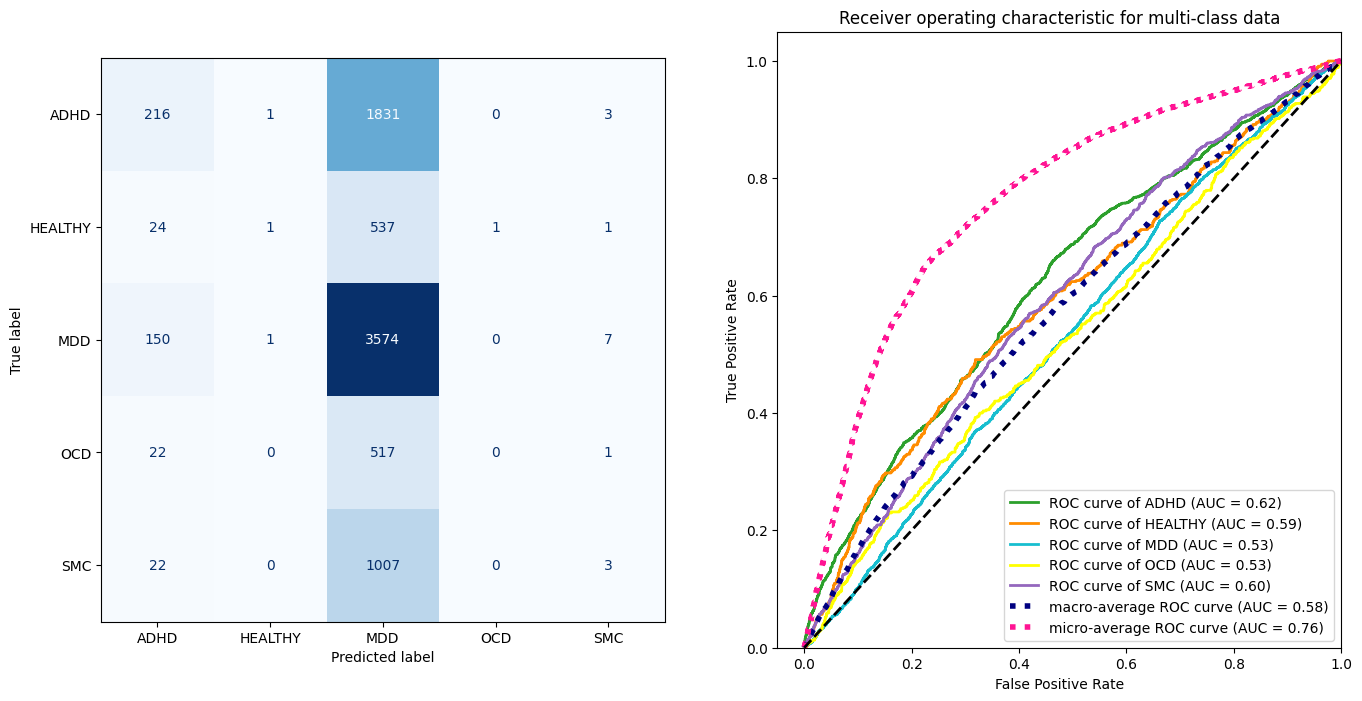

In [47]:
# final pipeline
best_params = {}
for hyperparameter in gridsearch.best_params_:
    key = hyperparameter[20:]
    best_params[key] = gridsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 101), X_test.shape = (1980, 101), Y_train.shape = (5939,), Y_test.shape = (1980,)


Text(0.5, 1.0, 'Difference between training - testing data')

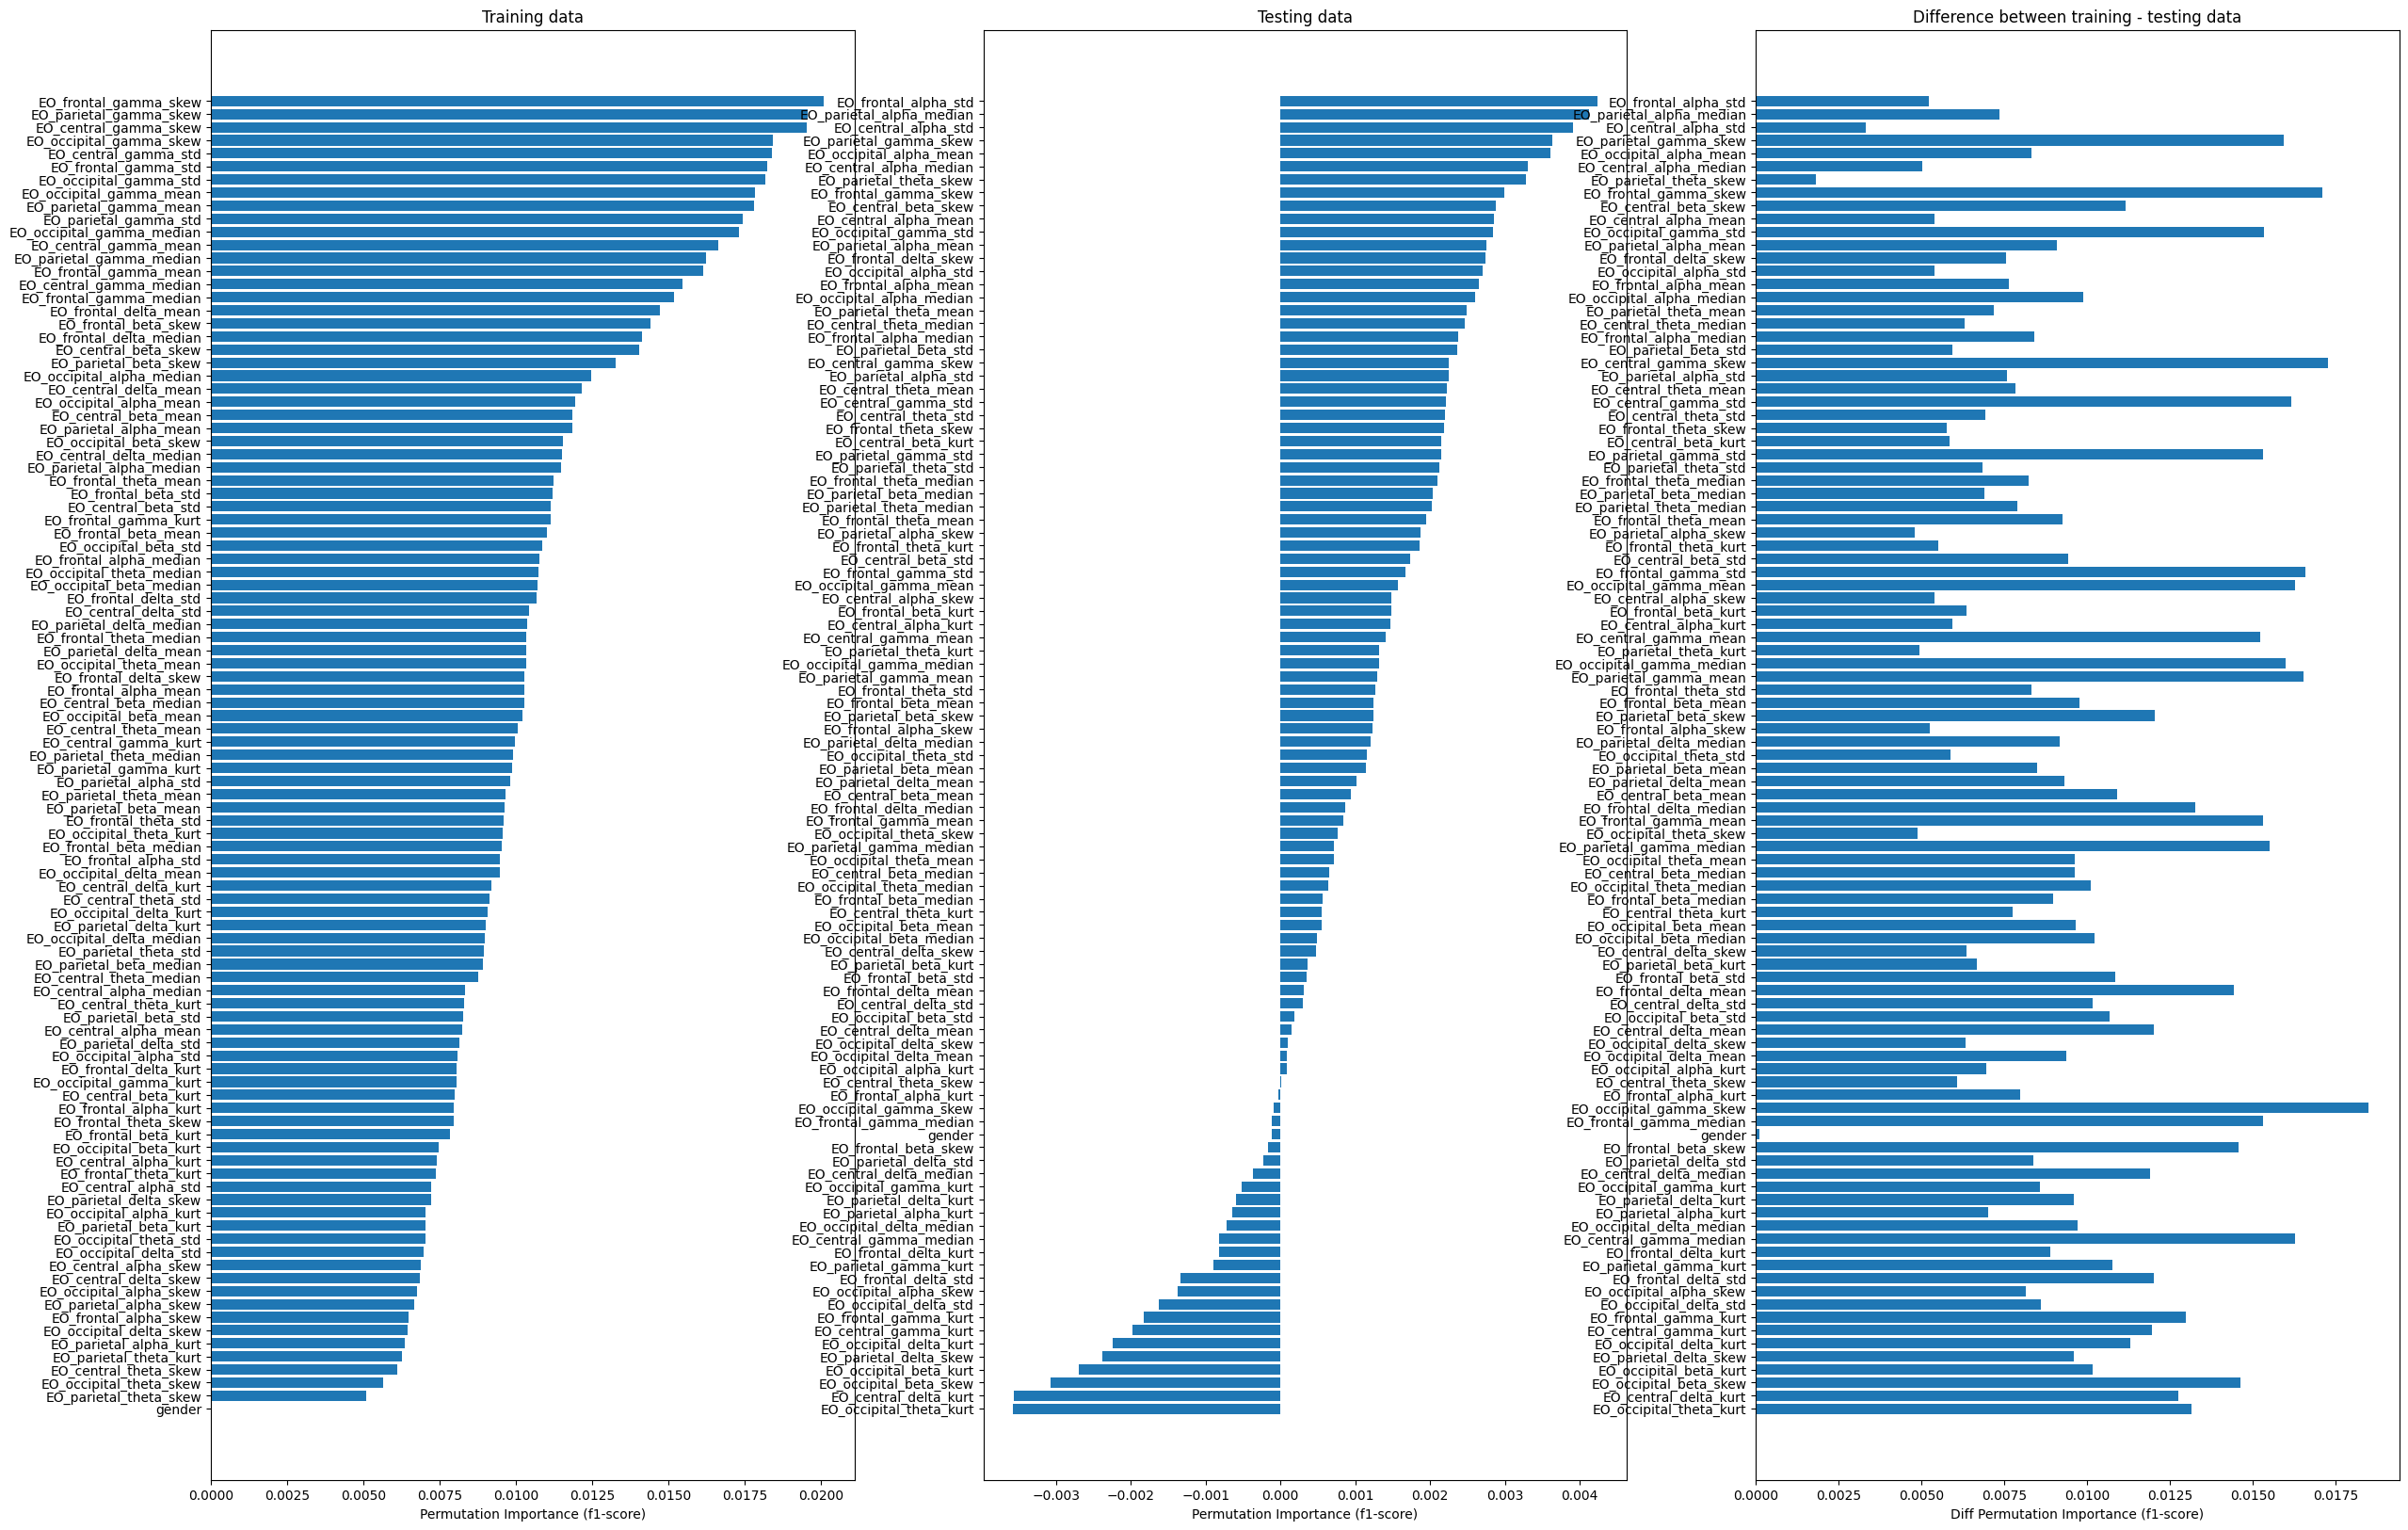

In [48]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

### SVC Without skew & kurt

In [6]:
# remove skewness & kurtosis features
### THIS VERSION INCLUDES BIG MISTAKE BECAUSE THE FEATURE SETS WITH NO SKEW/KURT WERE CREATED WITH THE WRONG DATAFRAME (FOR EXAMPLE FOR df_features_ec_nosk SHOULD BE df_features_ec)
df_features_ec_nosk = df_features[df_features.columns[~(df_features.columns.str.endswith('kurt') | df_features.columns.str.endswith('skew'))]]
df_features_eo_nosk = df_features[df_features.columns[~(df_features.columns.str.endswith('kurt') | df_features.columns.str.endswith('skew'))]]
df_features_ratio_nosk = df_features[df_features.columns[~(df_features.columns.str.endswith('kurt') | df_features.columns.str.endswith('skew'))]]
df_features_ec_nosk

ID  age  gender diagnosis  epoch  EO_frontal_delta_std  \
0     sub-87963725   78     0.0       SMC      1              0.356333   
1     sub-87963725   78     0.0       SMC      2              0.389402   
2     sub-87963725   78     0.0       SMC      3              0.380304   
3     sub-87963725   78     0.0       SMC      4              0.402746   
4     sub-87963725   78     0.0       SMC      5              0.373939   
...            ...  ...     ...       ...    ...                   ...   
7927  sub-88077613   58     1.0       MDD      8              0.372652   
7928  sub-88077613   58     1.0       MDD      9              0.388591   
7929  sub-88077613   58     1.0       MDD     10              0.368684   
7930  sub-88077613   58     1.0       MDD     11              0.387149   
7931  sub-88077613   58     1.0       MDD     12              0.389616   

      EO_frontal_delta_mean  EO_frontal_delta_median  EO_central_delta_std  \
0                 -0.132612                -0.133959              0.357613   
1                 -0.171387                -0.162584              0.350056   
2                 -0.183911                -0.181152              0.400932   
3                 -0.184317                -0.168257              0.390024   
4                 -0.146345                -0.147746              0.369023   
...                     ...                      ...                   ...   
7927              -0.170264                -0.162864              0.420061   
7928              -0.152992                -0.150522              0.422169   
7929              -0.145551                -0.140290              0.388477   
7930              -0.157329                -0.153514              0.406189   
7931              -0.147135                -0.141548              0.382326   

      EO_central_delta_mean  ...  ratio_frontal_gamma_median  \
0                 -0.135223  ...                    1.088809   
1                 -0.137251  ...                    1.023718   
2                 -0.184120  ...                    0.897544   
3                 -0.176762  ...                    1.040773   
4                 -0.142722  ...                    1.170474   
...                     ...  ...                         ...   
7927              -0.205198  ...                    1.102903   
7928              -0.169798  ...                    0.837548   
7929              -0.164175  ...                    0.973892   
7930              -0.169432  ...                    1.209368   
7931              -0.155693  ...                    1.174757   

      ratio_central_gamma_std  ratio_central_gamma_mean  \
0                    0.981801                  1.011443   
1                    0.964165                  0.890521   
2                    0.950073                  0.881429   
3                    0.977124                  1.006389   
4                    0.964456                  1.000649   
...                       ...                       ...   
7927                 1.021859                  1.095257   
7928                 1.000625                  0.995437   
7929                 1.014266                  1.096612   
7930                 1.067121                  1.077308   
7931                 1.018012                  1.013280   

      ratio_central_gamma_median  ratio_parietal_gamma_std  \
0                       1.049546                  0.959294   
1                       0.973697                  0.914216   
2                       0.865614                  0.928423   
3                       0.987585                  0.955074   
4                       1.040638                  0.894156   
...                          ...                       ...   
7927                    0.988643                  1.018466   
7928                    0.979641                  1.083894   
7929                    0.884879                  0.957229   
7930                    1.263943                  1.164024   
7931                    1.1396

#### ratio feature set

In [50]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_ratio_nosk['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['ratio']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ratio_nosk[numeric_cols + cat_cols]
Y = df_features_ratio_nosk['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# hyperparameter ranges for GridSearch
param_grid = {
'rbf_svm__estimator__C': [0.01, 0.1, 1, 10, 100],
'rbf_svm__estimator__gamma': [0.1, 1, 10, 100],
'rbf_svm__estimator__kernel': ['rbf'],
'rbf_svm__estimator__class_weight': ['balanced']
}

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(class_weight = 'balanced')))]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

# define gridsearch
gridsearch = GridSearchCV(pipeline,
                        param_grid = param_grid,
                        cv = cv_inner, # use inner cv for hyperparameter tuning
                        scoring = f1_scorer,
                        error_score = 'raise',
                        return_train_score = True,
                        n_jobs=-1,
                        verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
gridsearch_fit = gridsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {gridsearch_fit.best_params_}')
print(f'Best f1-score: {gridsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
svm_test_score = cross_val_score(gridsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 fit_params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('SVM test scores:', svm_test_score)
print('Mean SVM test score:', np.mean(svm_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}
Best f1-score: 0.378694584295991


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1086: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1086: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1086: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVM test scores: [0.36413867 0.36646414 0.38093324 0.38711823 0.37366057]
Mean SVM test score: 0.3744629683090584


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.7min finished


{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


f1_score: 0.3781472440950835

classification report:
               precision    recall  f1-score   support

        ADHD       0.36      0.37      0.37      2051
     HEALTHY       0.07      0.02      0.04       564
         MDD       0.49      0.63      0.55      3732
         OCD       0.10      0.04      0.06       540
         SMC       0.17      0.10      0.13      1032

    accuracy                           0.41      7919
   macro avg       0.24      0.23      0.23      7919
weighted avg       0.36      0.41      0.38      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


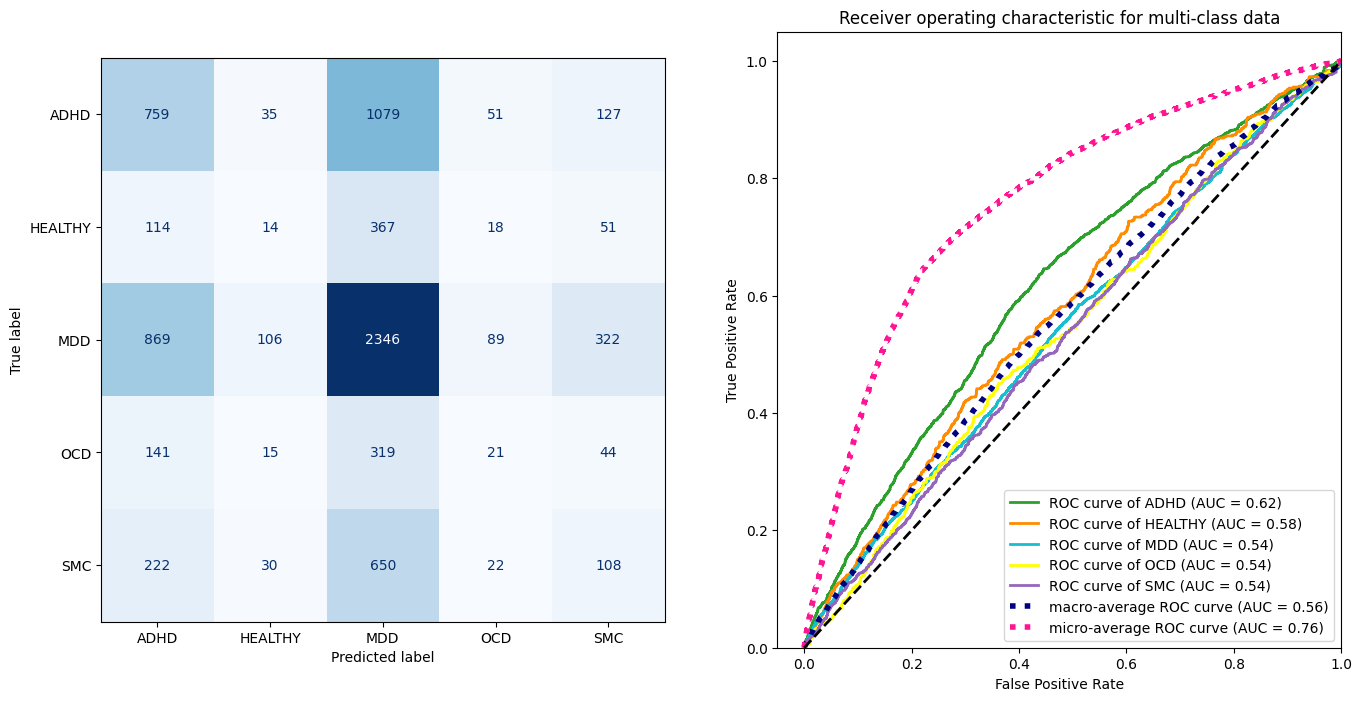

In [51]:
# final pipeline
best_params = {}
for hyperparameter in gridsearch.best_params_:
    key = hyperparameter[20:]
    best_params[key] = gridsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 61), X_test.shape = (1980, 61), Y_train.shape = (5939,), Y_test.shape = (1980,)


Text(0.5, 1.0, 'Difference between training - testing data')

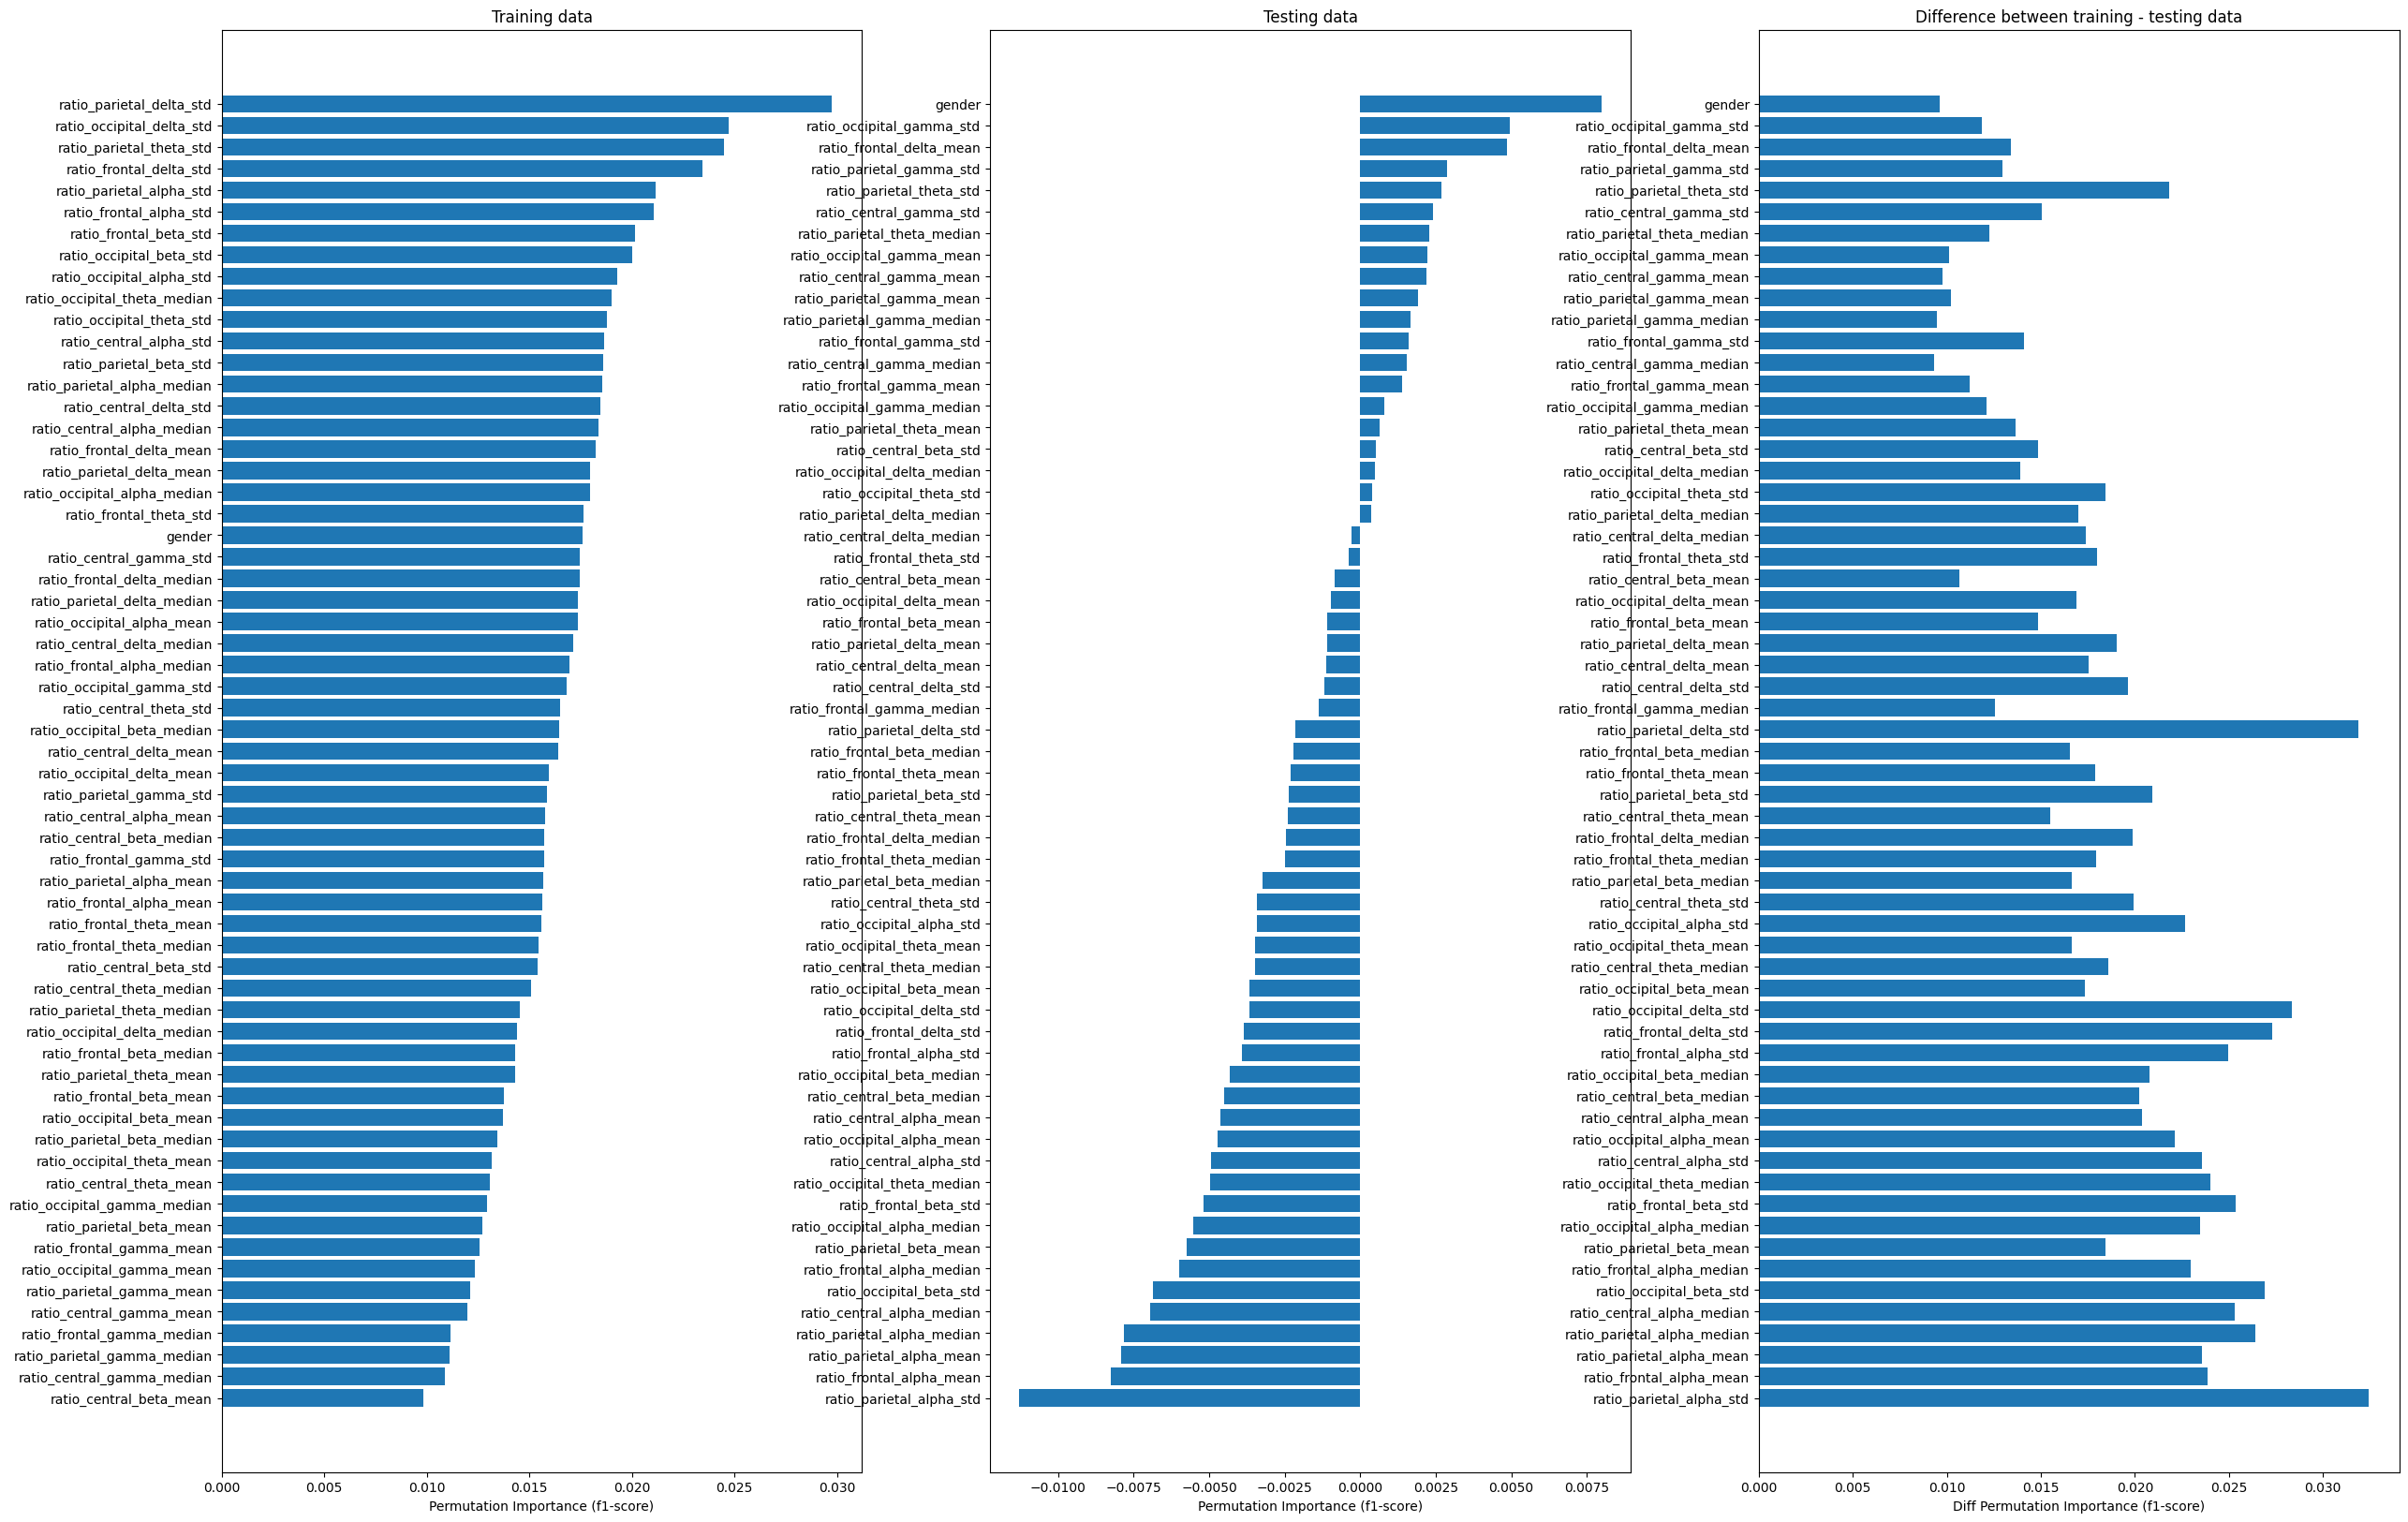

In [52]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EC feature set

In [53]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_ec_nosk['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EC']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ec_nosk[numeric_cols + cat_cols]
Y = df_features_ec_nosk['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# hyperparameter ranges for GridSearch
param_grid = {
'rbf_svm__estimator__C': [0.01, 0.1, 1, 10, 100],
'rbf_svm__estimator__gamma': [0.1, 1, 10, 100],
'rbf_svm__estimator__kernel': ['rbf'],
'rbf_svm__estimator__class_weight': ['balanced']
}

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(class_weight = 'balanced')))]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

# define gridsearch
gridsearch = GridSearchCV(pipeline,
                        param_grid = param_grid,
                        cv = cv_inner, # use inner cv for hyperparameter tuning
                        scoring = f1_scorer,
                        error_score = 'raise',
                        return_train_score = True,
                        n_jobs=-1,
                        verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
gridsearch_fit = gridsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {gridsearch_fit.best_params_}')
print(f'Best f1-score: {gridsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
svm_test_score = cross_val_score(gridsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 fit_params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('SVM test scores:', svm_test_score)
print('Mean SVM test score:', np.mean(svm_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}
Best f1-score: 0.3887447802656661


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1086: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1086: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVM test scores: [0.40537684 0.3832857  0.37734459 0.38944695 0.41944574]
Mean SVM test score: 0.39497996336115054


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min finished


{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.1s finished


f1_score: 0.39621988581264933

classification report:
               precision    recall  f1-score   support

        ADHD       0.42      0.43      0.42      2051
     HEALTHY       0.10      0.07      0.08       564
         MDD       0.51      0.58      0.54      3732
         OCD       0.06      0.04      0.05       540
         SMC       0.18      0.15      0.16      1032

    accuracy                           0.41      7919
   macro avg       0.26      0.25      0.25      7919
weighted avg       0.38      0.41      0.40      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.3s finished


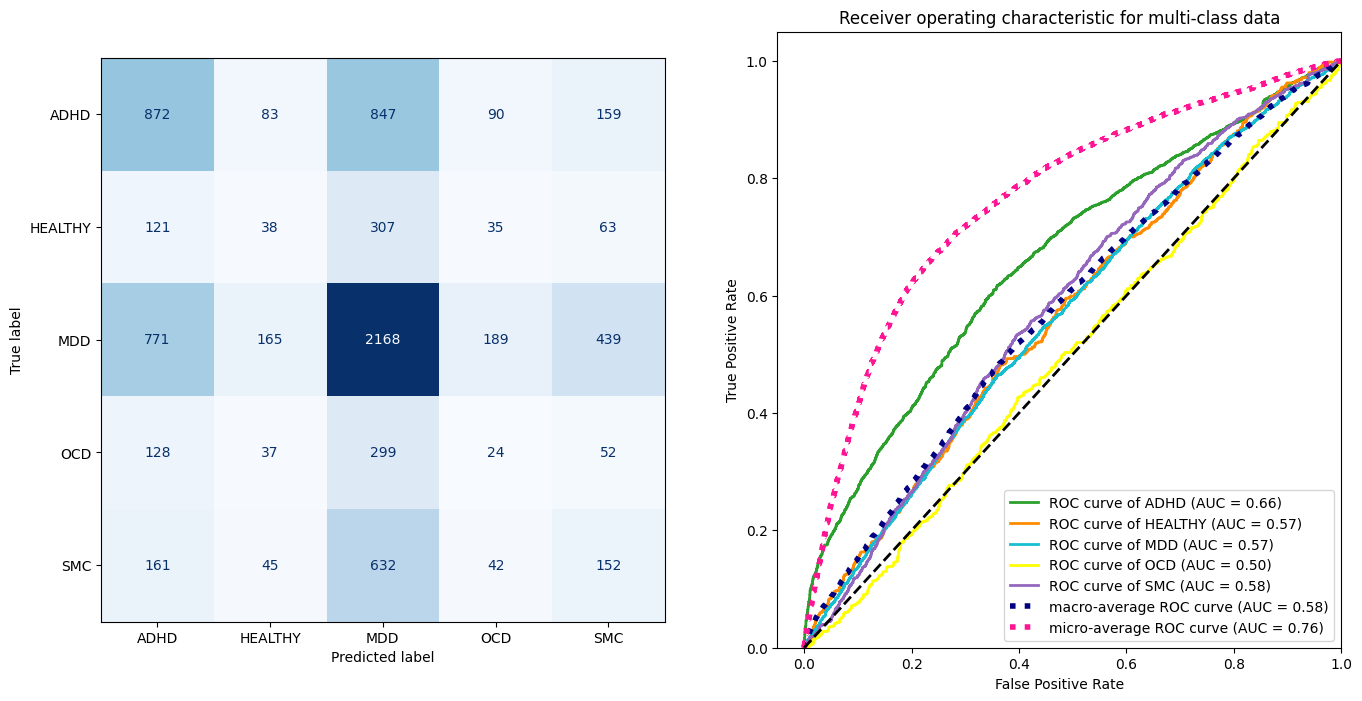

In [54]:
# final pipeline
best_params = {}
for hyperparameter in gridsearch.best_params_:
    key = hyperparameter[20:]
    best_params[key] = gridsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 61), X_test.shape = (1980, 61), Y_train.shape = (5939,), Y_test.shape = (1980,)


Text(0.5, 1.0, 'Difference between training - testing data')

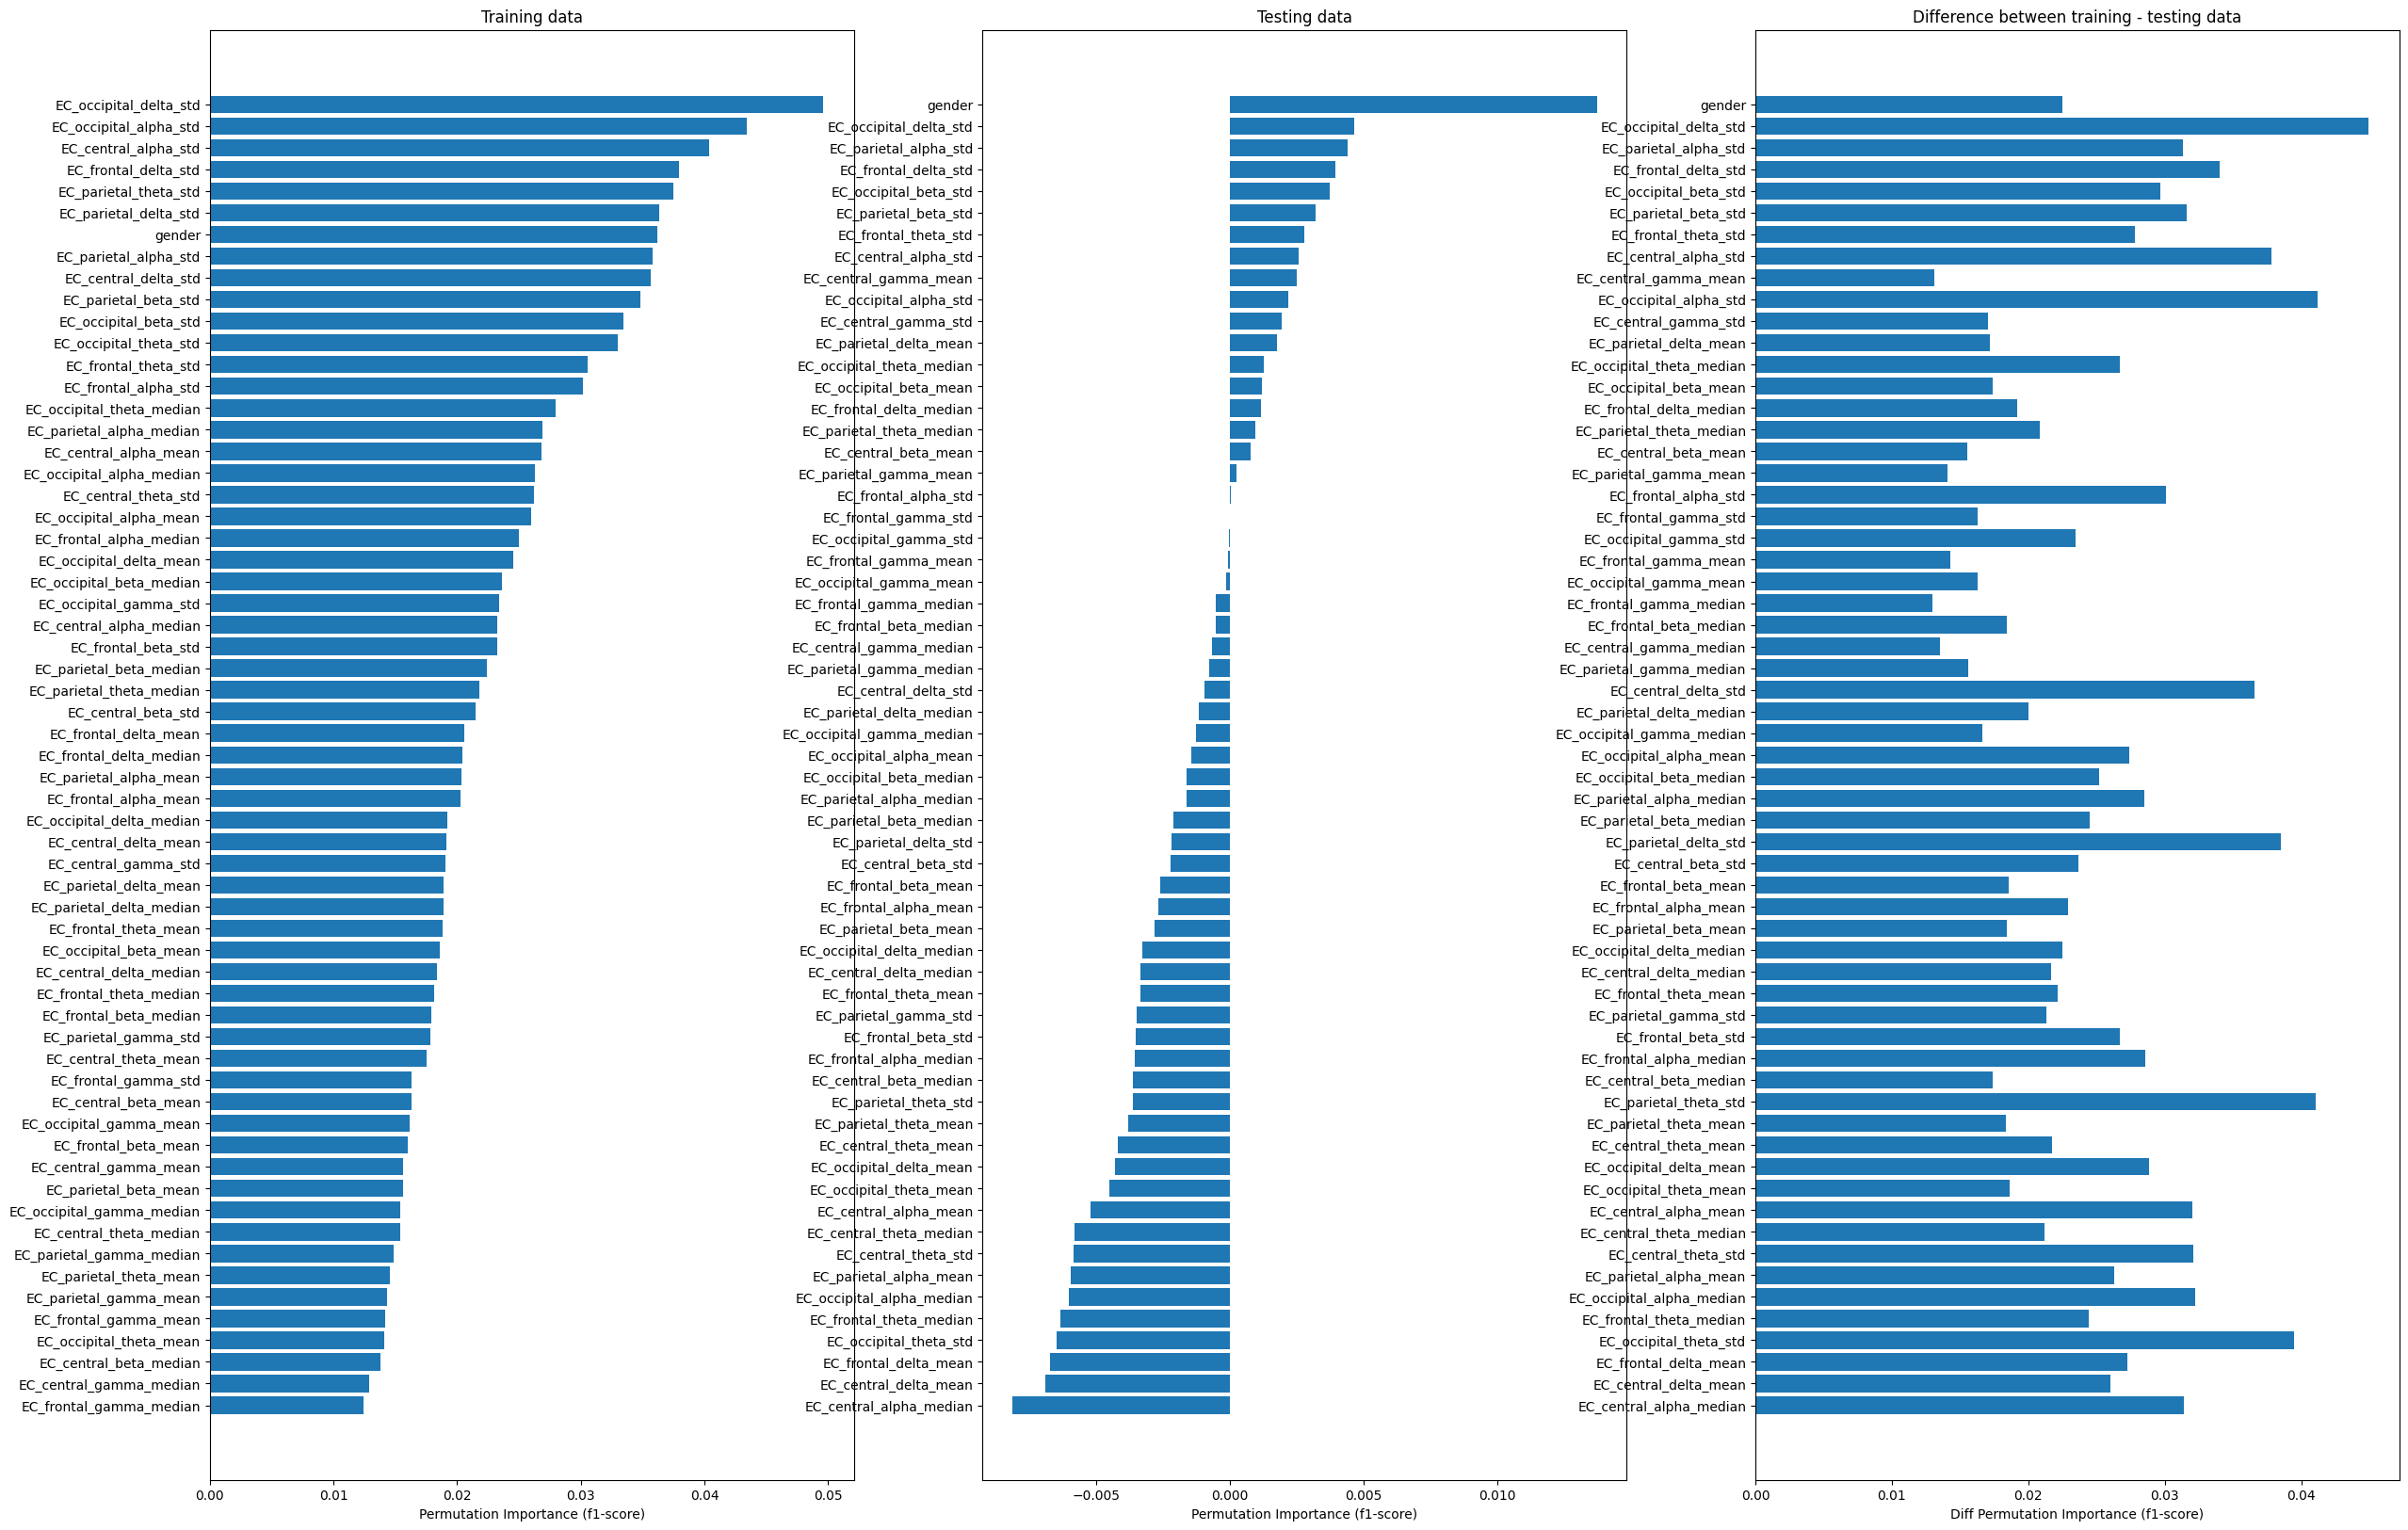

In [55]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EO feature set

In [56]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_eo_nosk['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_eo_nosk[numeric_cols + cat_cols]
Y = df_features_eo_nosk['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# hyperparameter ranges for GridSearch
param_grid = {
'rbf_svm__estimator__C': [0.01, 0.1, 1, 10, 100],
'rbf_svm__estimator__gamma': [0.1, 1, 10, 100],
'rbf_svm__estimator__kernel': ['rbf'],
'rbf_svm__estimator__class_weight': ['balanced']
}

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(class_weight = 'balanced')))]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

# define gridsearch
gridsearch = GridSearchCV(pipeline,
                        param_grid = param_grid,
                        cv = cv_inner, # use inner cv for hyperparameter tuning
                        scoring = f1_scorer,
                        error_score = 'raise',
                        return_train_score = True,
                        n_jobs=-1,
                        verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
gridsearch_fit = gridsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {gridsearch_fit.best_params_}')
print(f'Best f1-score: {gridsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
svm_test_score = cross_val_score(gridsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 fit_params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('SVM test scores:', svm_test_score)
print('Mean SVM test score:', np.mean(svm_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}
Best f1-score: 0.3910001205087689


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1086: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/tsmolders/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1086: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1086: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


SVM test scores: [0.37566233 0.39997706 0.37000614 0.39577948 0.40406456]
Mean SVM test score: 0.3890979136786258


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min finished


{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.2s finished


f1_score: 0.3893530905904841

classification report:
               precision    recall  f1-score   support

        ADHD       0.41      0.40      0.41      2051
     HEALTHY       0.14      0.13      0.13       564
         MDD       0.50      0.53      0.52      3732
         OCD       0.09      0.07      0.08       540
         SMC       0.20      0.19      0.20      1032

    accuracy                           0.39      7919
   macro avg       0.27      0.27      0.27      7919
weighted avg       0.38      0.39      0.39      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.5s finished


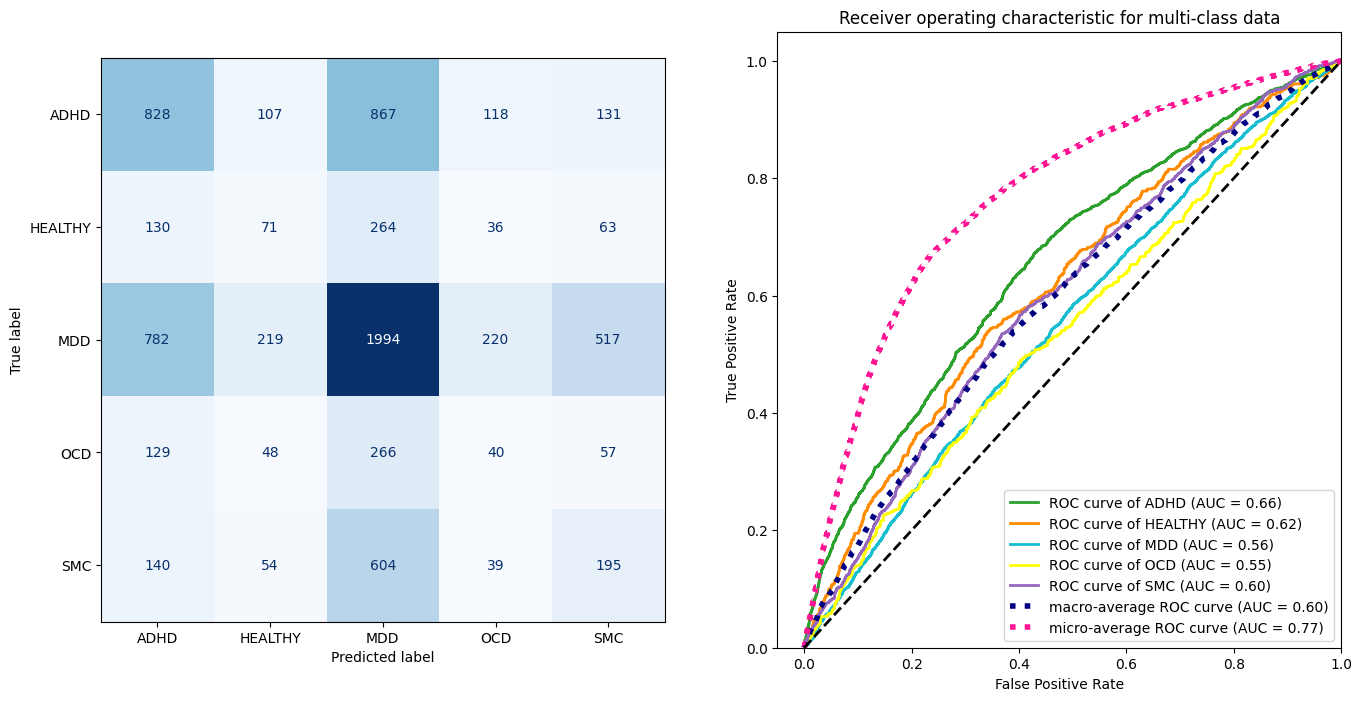

In [57]:
# final pipeline
best_params = {}
for hyperparameter in gridsearch.best_params_:
    key = hyperparameter[20:]
    best_params[key] = gridsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 61), X_test.shape = (1980, 61), Y_train.shape = (5939,), Y_test.shape = (1980,)


Text(0.5, 1.0, 'Difference between training - testing data')

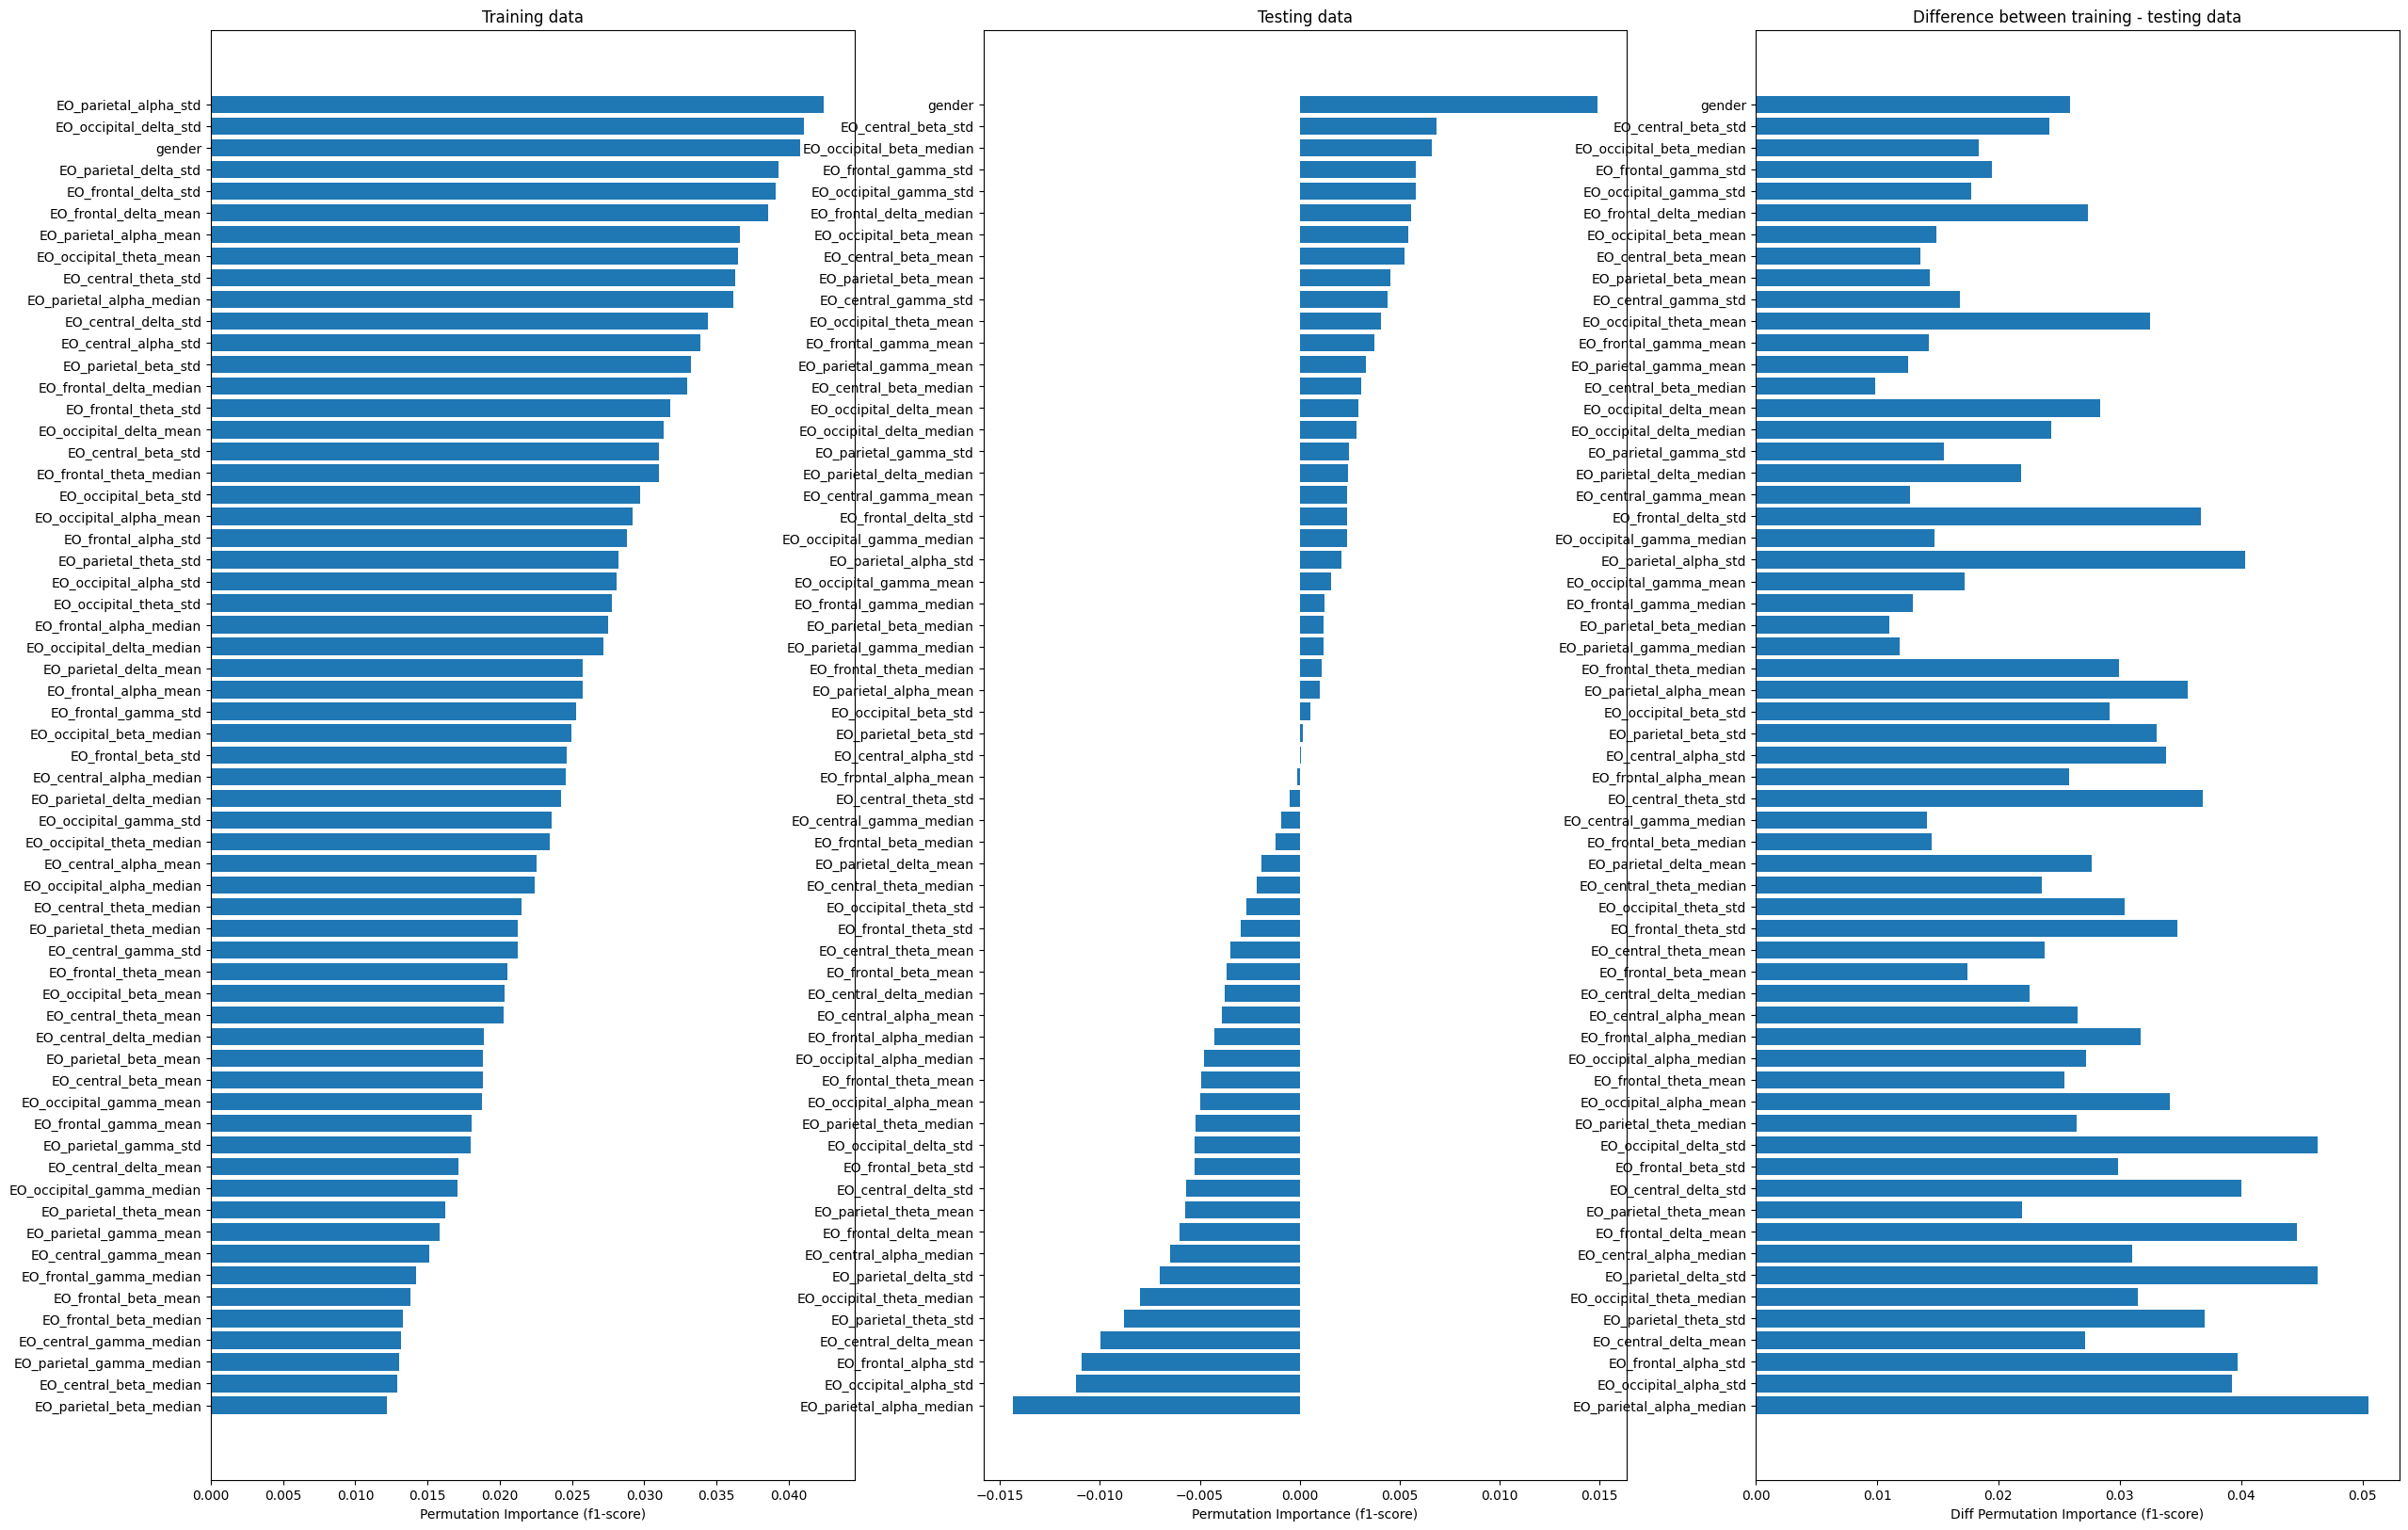

In [58]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

## Random Forest

#### ratio feature set

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['ratio']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ratio[numeric_cols + cat_cols]
Y = df_features_ratio['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'RF__n_estimators': n_estimators,
               'RF__max_features': max_features,
               'RF__max_depth': max_depth,
               'RF__min_samples_split': min_samples_split,
               'RF__min_samples_leaf': min_samples_leaf,
               'RF__bootstrap': bootstrap}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
rf_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 fit_params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('RF test scores:', rf_test_score)
print('Mean RF test score:', np.mean(rf_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best parameters: {'RF__n_estimators': 200, 'RF__min_samples_split': 2, 'RF__min_samples_leaf': 1, 'RF__max_features': 'sqrt', 'RF__max_depth': 110, 'RF__bootstrap': False}
Best f1-score: 0.3923245732670382


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RF test scores: [0.36710192 0.38413822 0.39141746 0.40551864 0.39588039]
Mean RF test score: 0.3888113272816334


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 90.0min finished


{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.8s finished


f1_score: 0.38798489818293064

classification report:
               precision    recall  f1-score   support

        ADHD       0.49      0.26      0.34      2051
     HEALTHY       0.00      0.00      0.00       564
         MDD       0.49      0.90      0.64      3732
         OCD       0.00      0.00      0.00       540
         SMC       0.12      0.00      0.00      1032

    accuracy                           0.49      7919
   macro avg       0.22      0.23      0.20      7919
weighted avg       0.37      0.49      0.39      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.5s finished


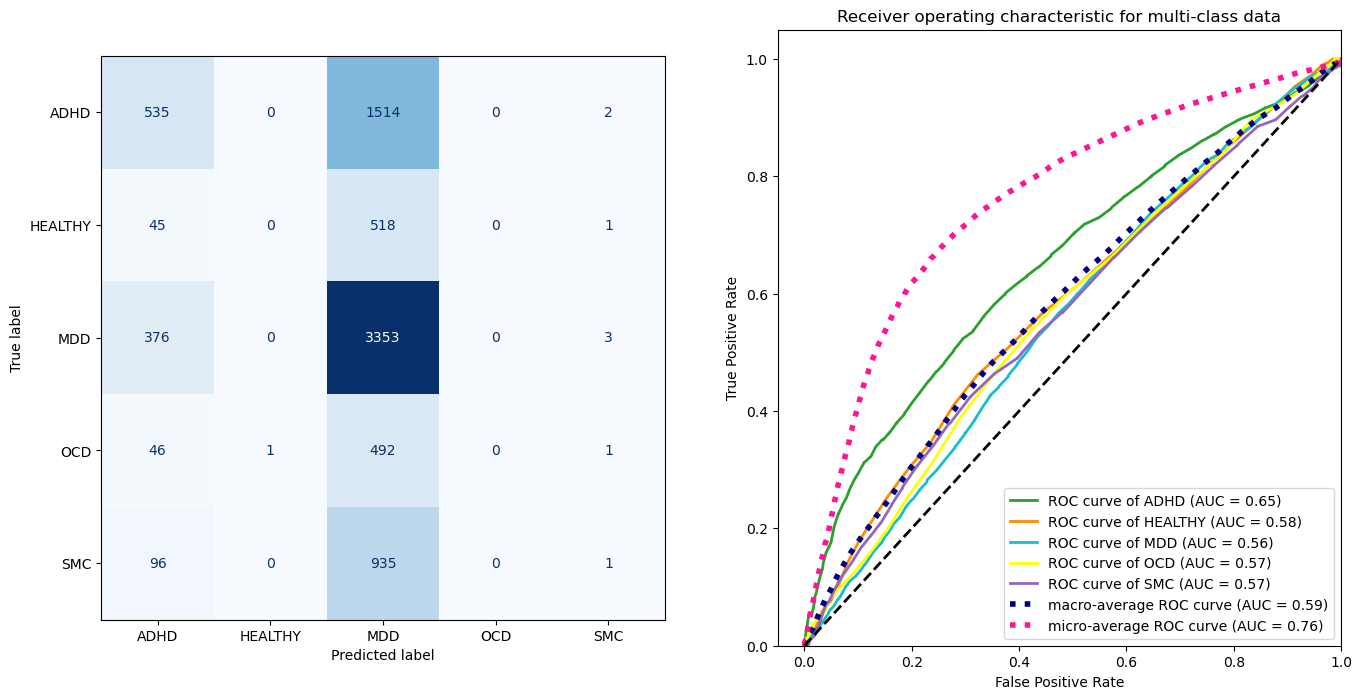

In [12]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[4:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 101), X_test.shape = (1980, 101), Y_train.shape = (5939,), Y_test.shape = (1980,)


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0.5, 1.0, 'Difference between training - testing data')

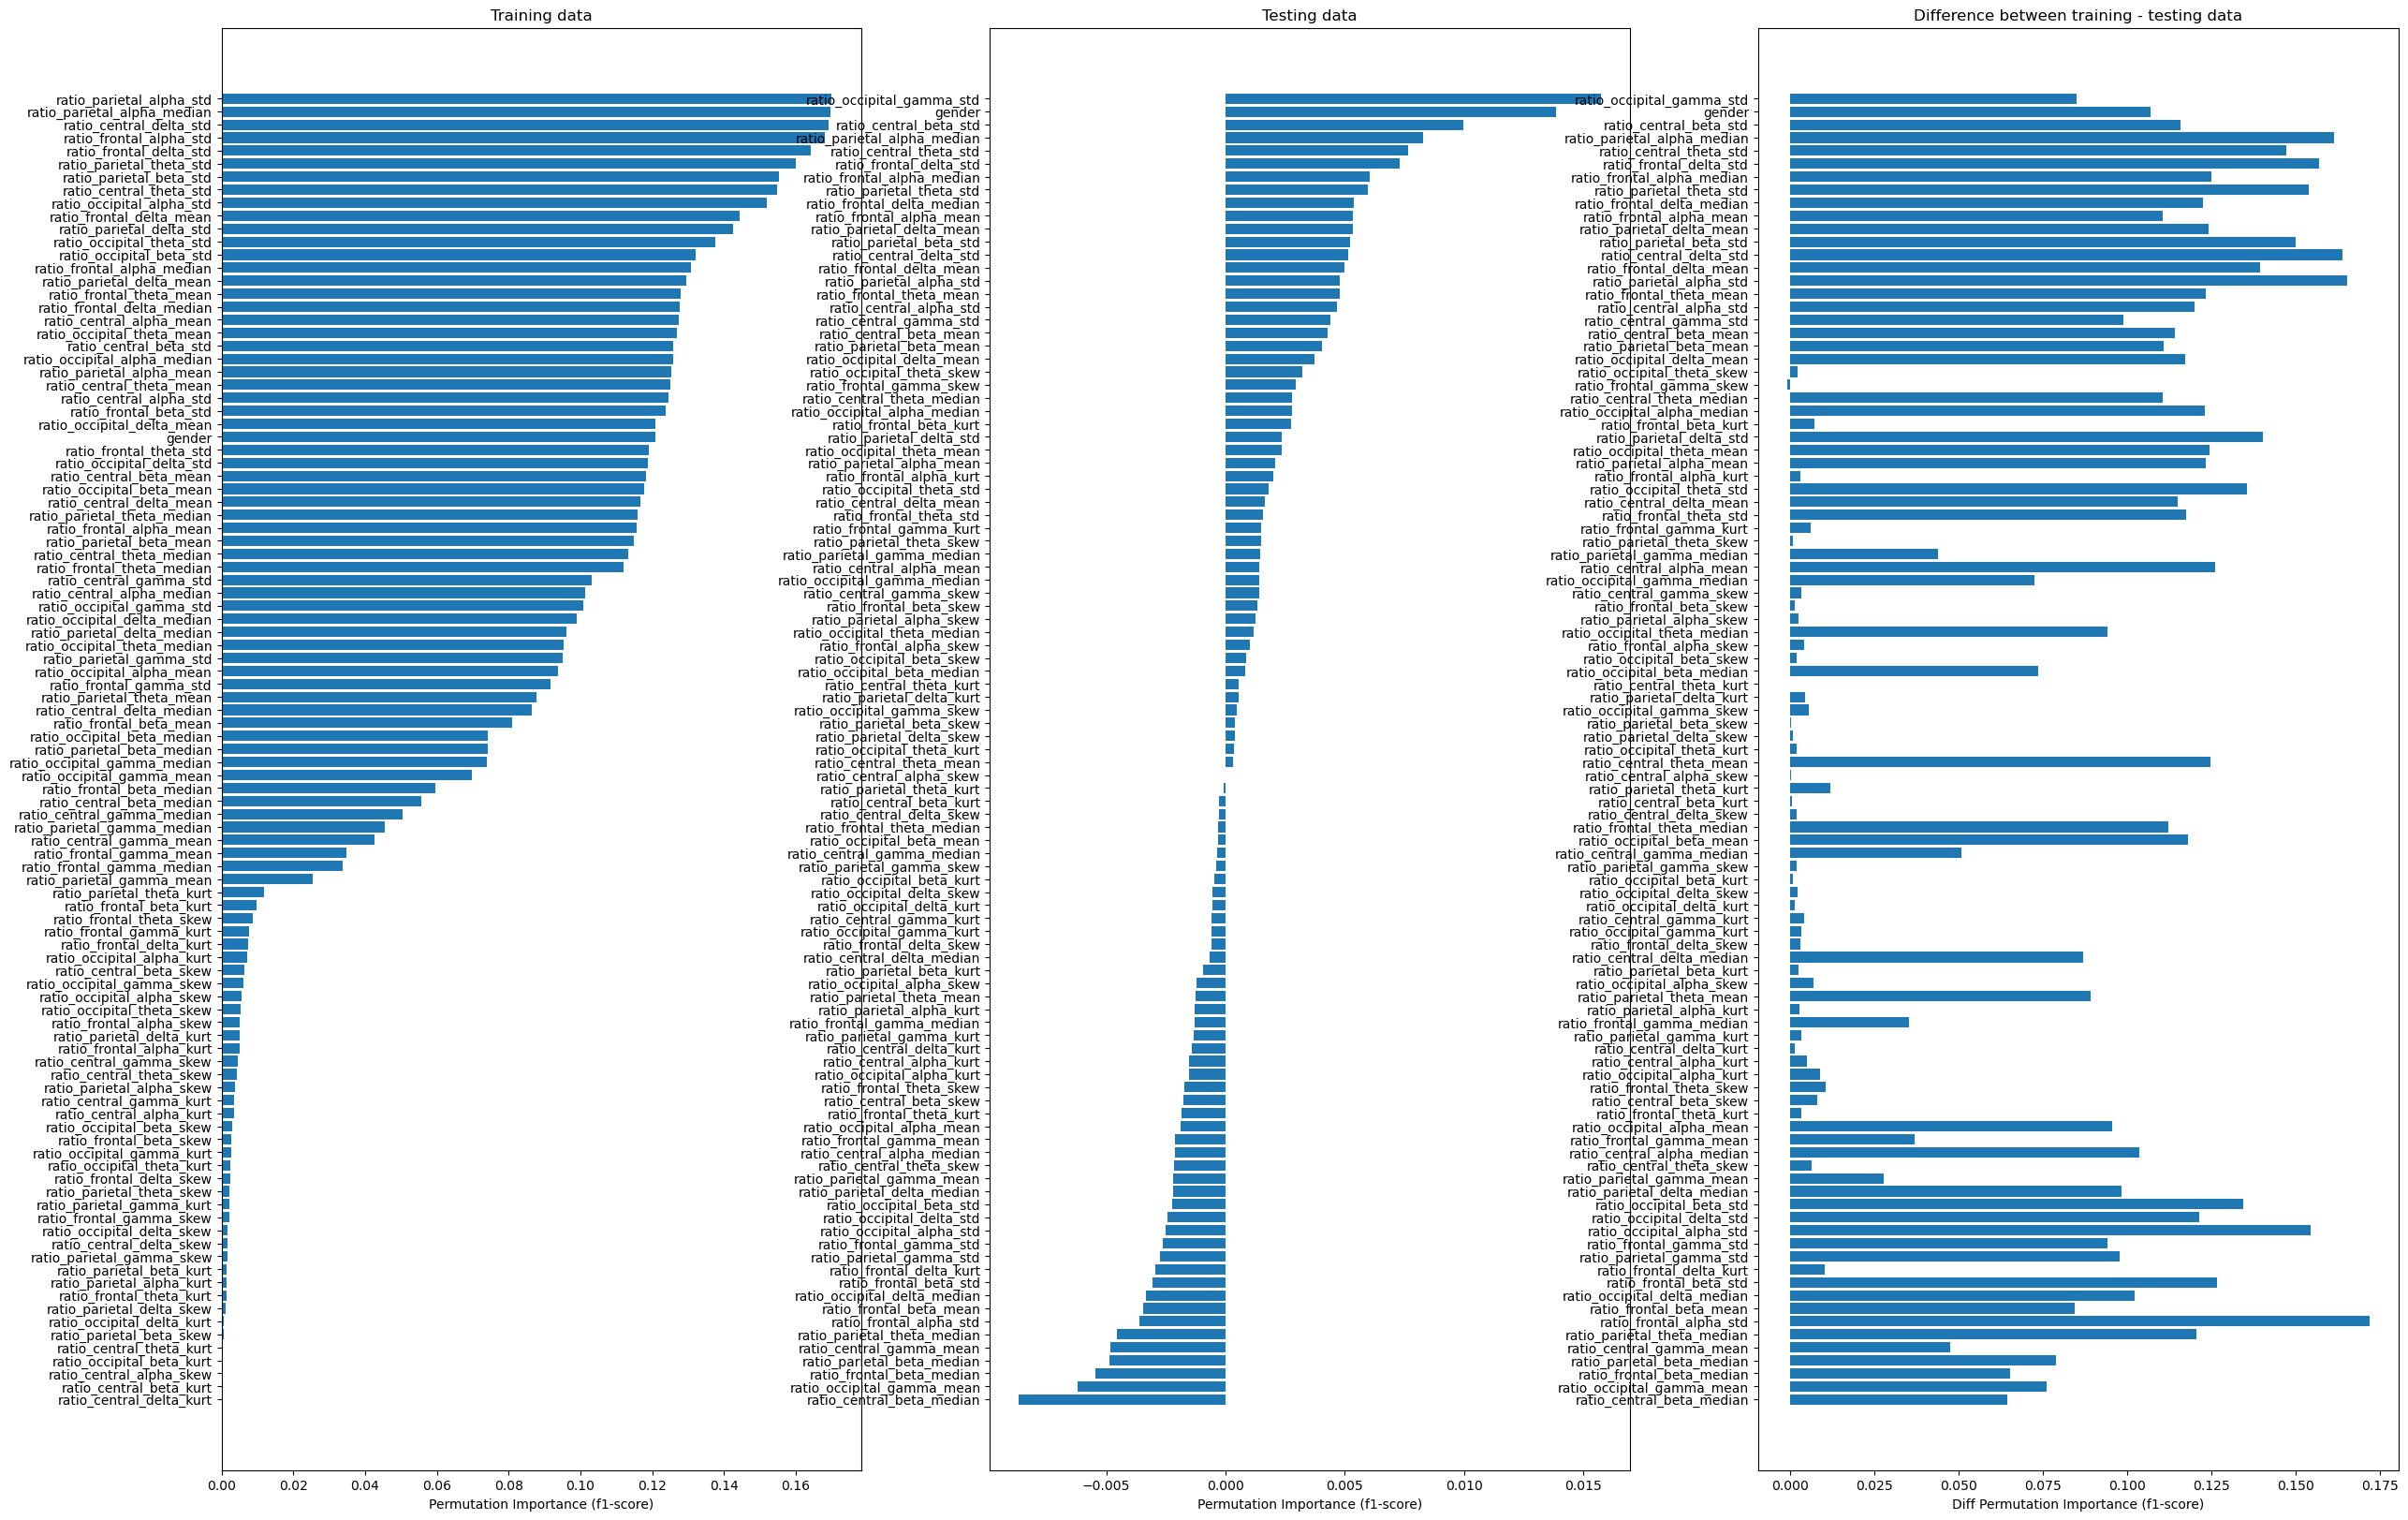

In [13]:
# using permutation_importance()
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EC feature set

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EC']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ec[numeric_cols + cat_cols]
Y = df_features_ec['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'RF__n_estimators': n_estimators,
               'RF__max_features': max_features,
               'RF__max_depth': max_depth,
               'RF__min_samples_split': min_samples_split,
               'RF__min_samples_leaf': min_samples_leaf,
               'RF__bootstrap': bootstrap}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
rf_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('RF test scores:', rf_test_score)
print('Mean RF test score:', np.mean(rf_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'RF__n_estimators': 1400, 'RF__min_samples_split': 2, 'RF__min_samples_leaf': 2, 'RF__max_features': 'sqrt', 'RF__max_depth': 50, 'RF__bootstrap': False}
Best f1-score: 0.41292469735870035


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RF test scores: [0.39852935 0.39615176 0.41107757 0.42589018 0.41693596]
Mean RF test score: 0.4097169638627106


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 91.2min finished


{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


f1_score: 0.4094584503925421

classification report:
               precision    recall  f1-score   support

        ADHD       0.60      0.30      0.40      2051
     HEALTHY       0.00      0.00      0.00       564
         MDD       0.50      0.92      0.65      3732
         OCD       0.00      0.00      0.00       540
         SMC       0.50      0.00      0.01      1032

    accuracy                           0.51      7919
   macro avg       0.32      0.24      0.21      7919
weighted avg       0.46      0.51      0.41      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


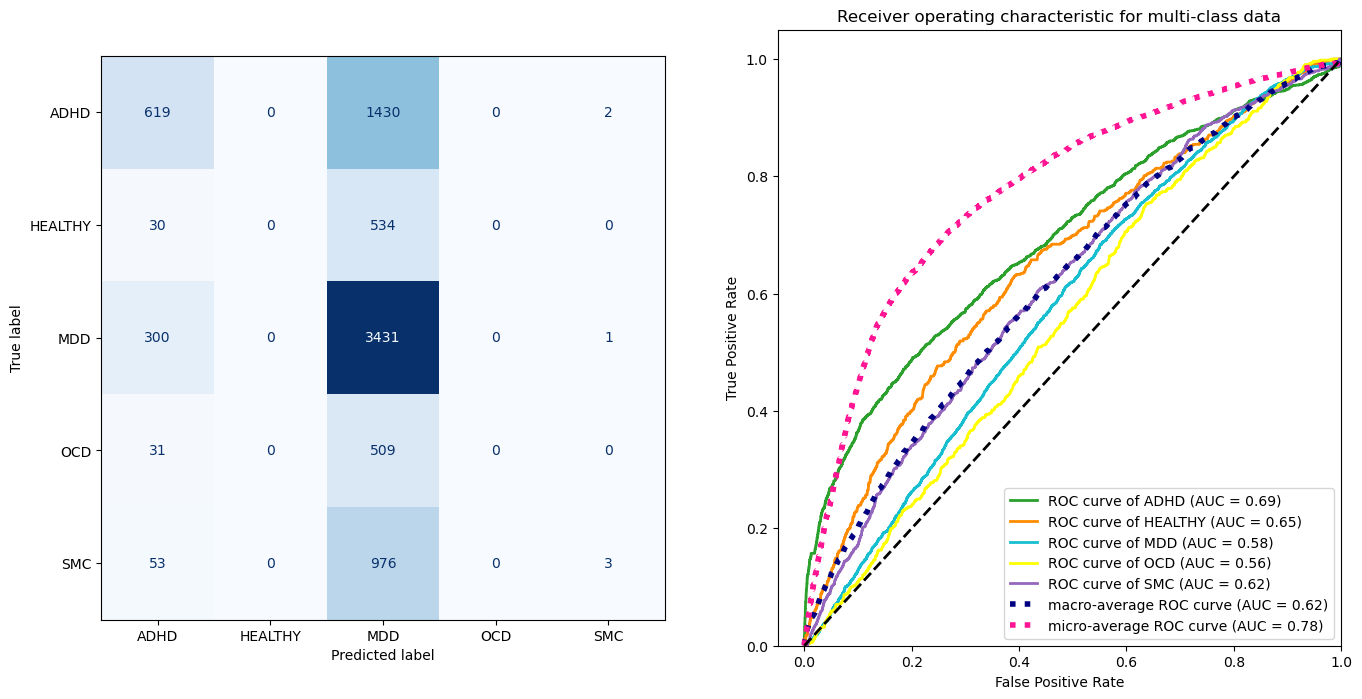

In [8]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[4:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 101), X_test.shape = (1980, 101), Y_train.shape = (5939,), Y_test.shape = (1980,)


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0.5, 1.0, 'Difference between training - testing data')

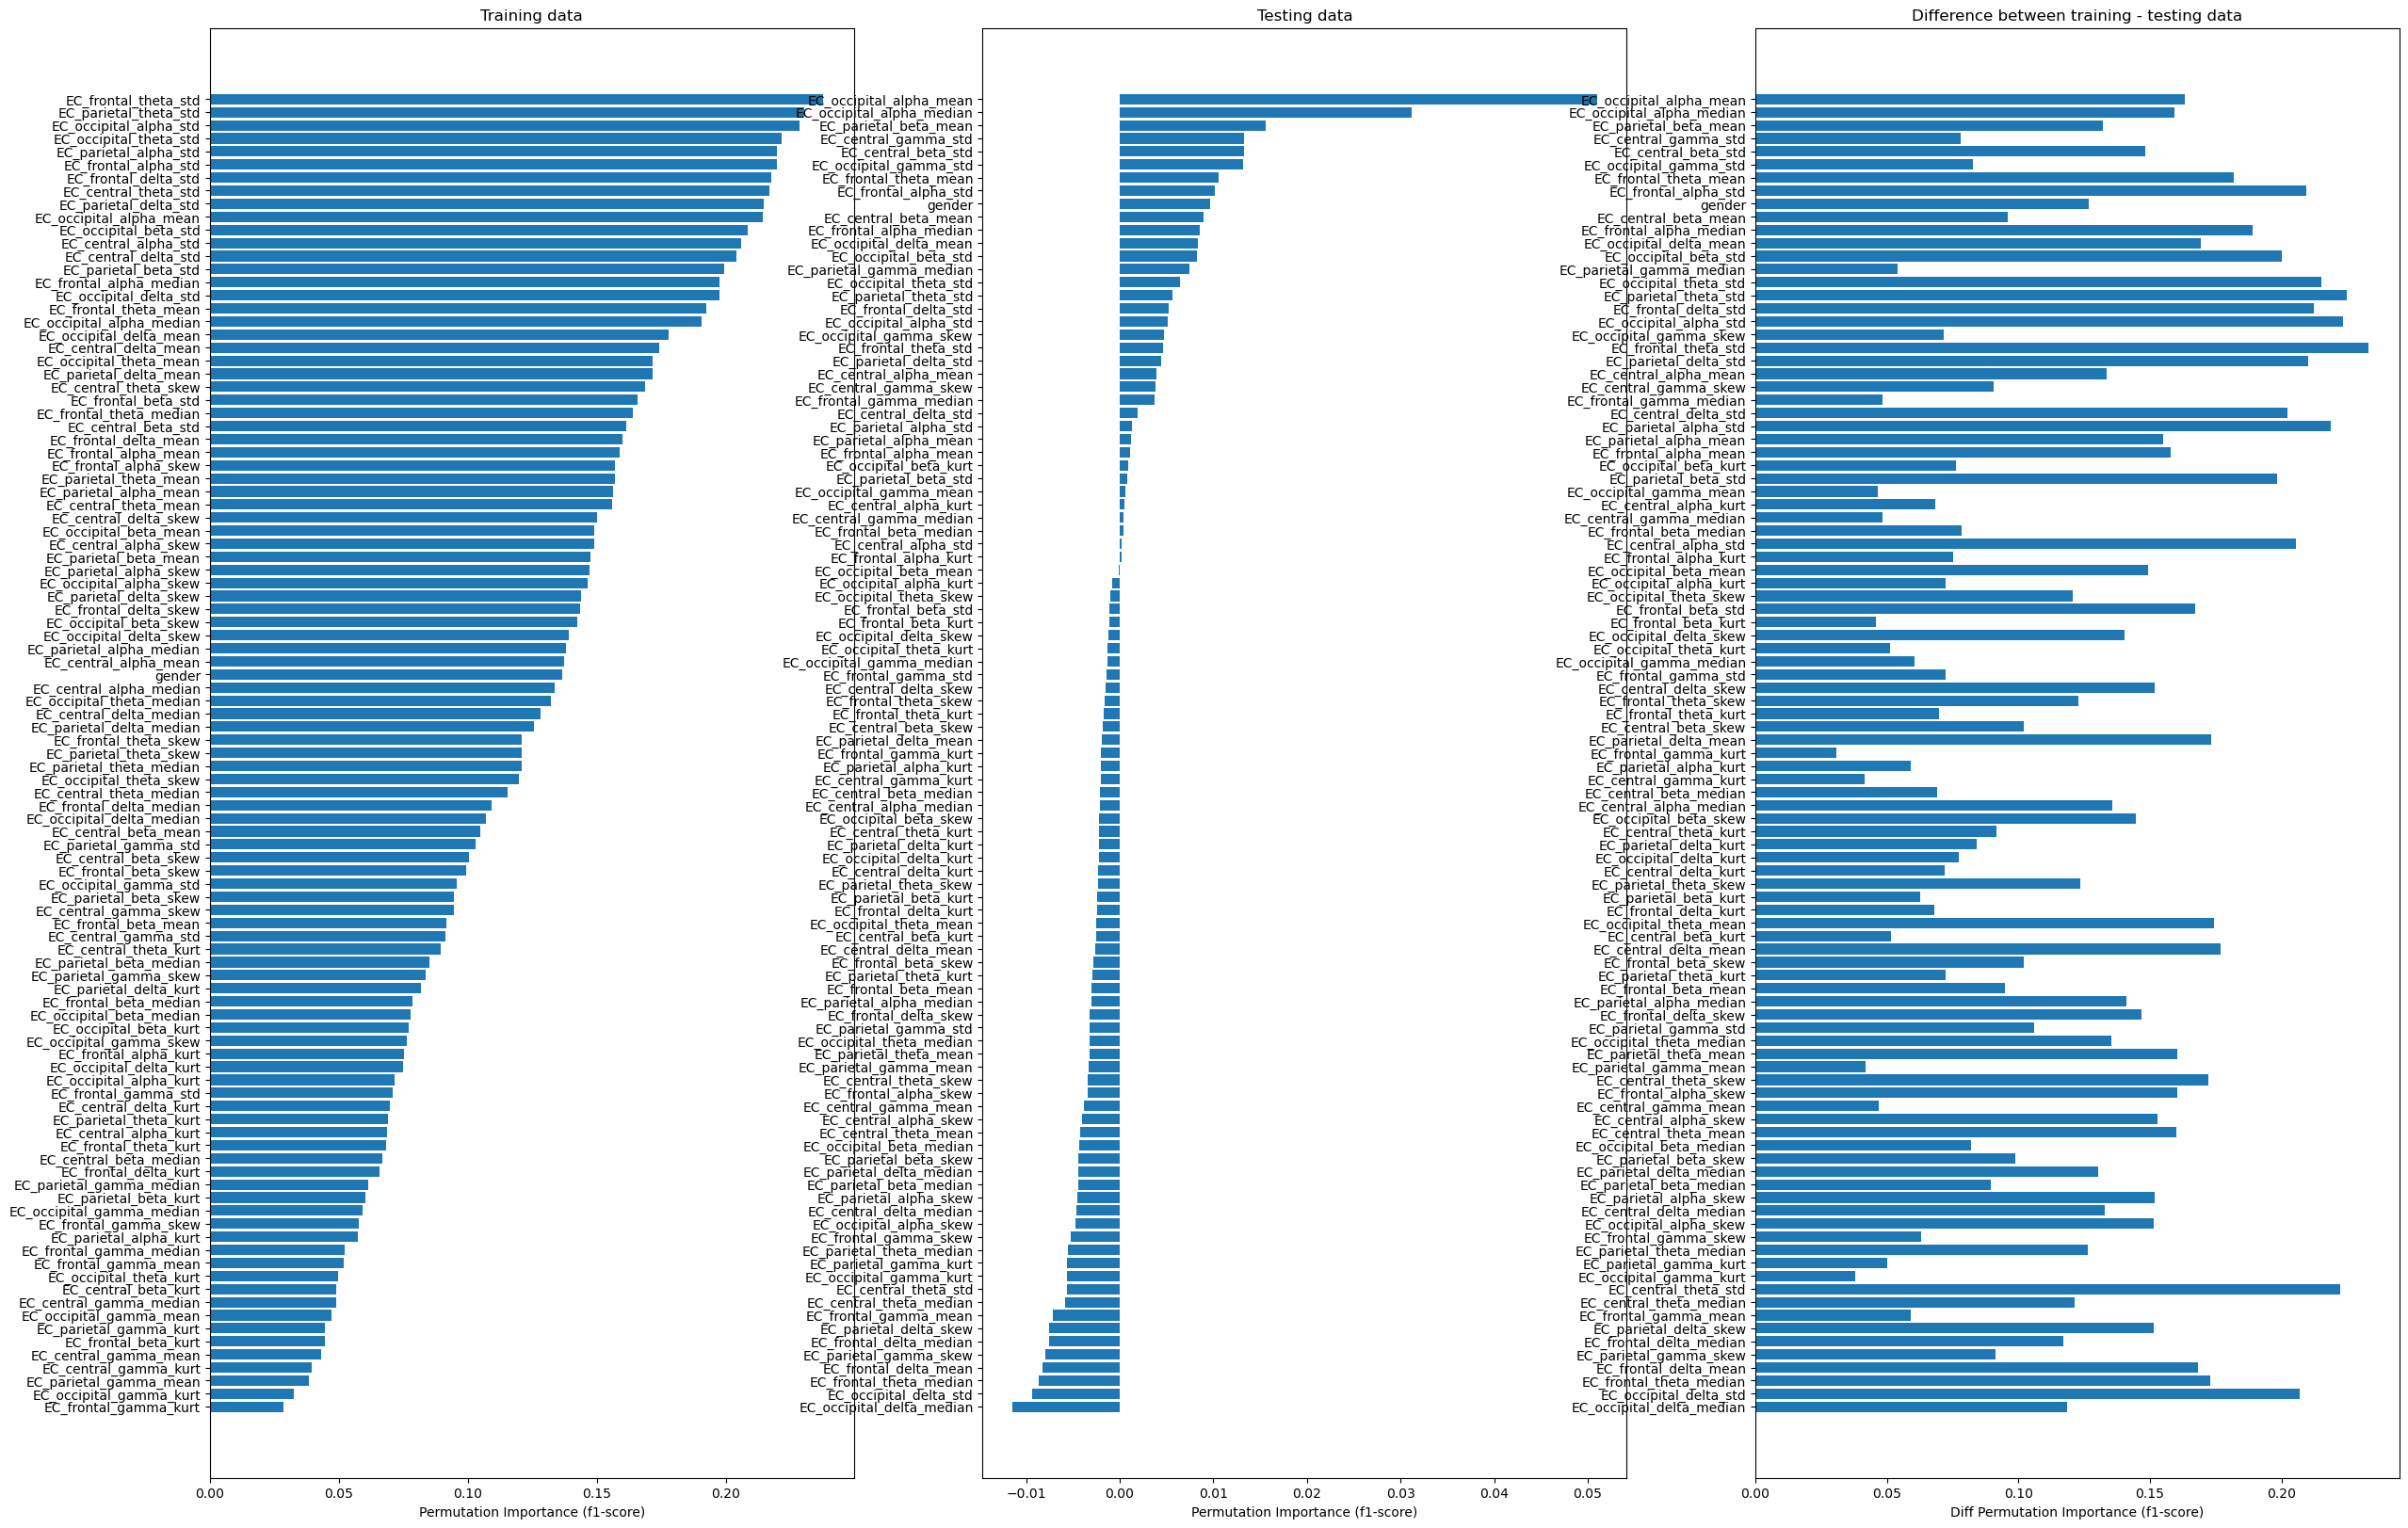

In [9]:
# using permutation_importance()
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EO feature set

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_eo[numeric_cols + cat_cols]
Y = df_features_eo['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'RF__n_estimators': n_estimators,
               'RF__max_features': max_features,
               'RF__max_depth': max_depth,
               'RF__min_samples_split': min_samples_split,
               'RF__min_samples_leaf': min_samples_leaf,
               'RF__bootstrap': bootstrap}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
rf_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('RF test scores:', rf_test_score)
print('Mean RF test score:', np.mean(rf_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'RF__n_estimators': 400, 'RF__min_samples_split': 2, 'RF__min_samples_leaf': 1, 'RF__max_features': 'sqrt', 'RF__max_depth': 40, 'RF__bootstrap': False}
Best f1-score: 0.4080104314120403


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RF test scores: [0.35871941 0.40394831 0.40952608 0.42460882 0.43260333]
Mean RF test score: 0.40588118878839374


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 85.8min finished


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.2s finished


f1_score: 0.40940916222464147

classification report:
               precision    recall  f1-score   support

        ADHD       0.57      0.30      0.39      2051
     HEALTHY       0.00      0.00      0.00       564
         MDD       0.50      0.92      0.65      3732
         OCD       0.00      0.00      0.00       540
         SMC       0.00      0.00      0.00      1032

    accuracy                           0.51      7919
   macro avg       0.21      0.24      0.21      7919
weighted avg       0.38      0.51      0.41      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.3s finished


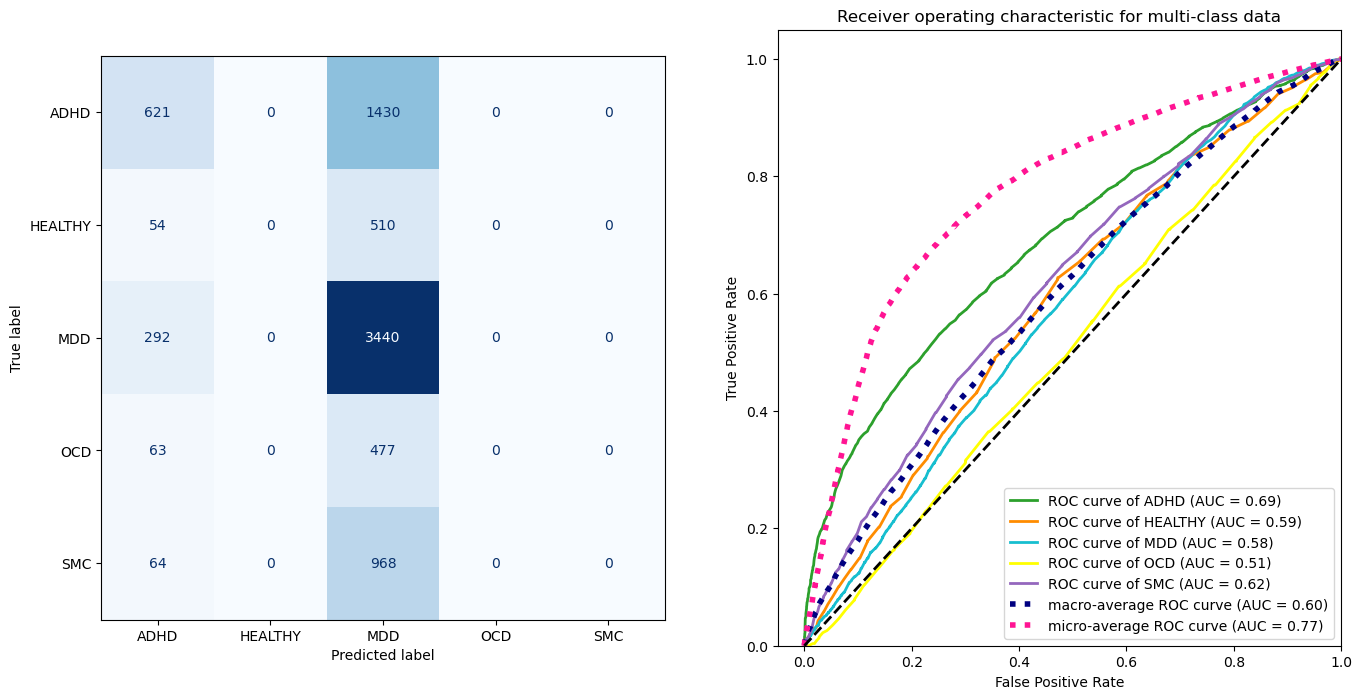

In [11]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[4:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 101), X_test.shape = (1980, 101), Y_train.shape = (5939,), Y_test.shape = (1980,)


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0.5, 1.0, 'Difference between training - testing data')

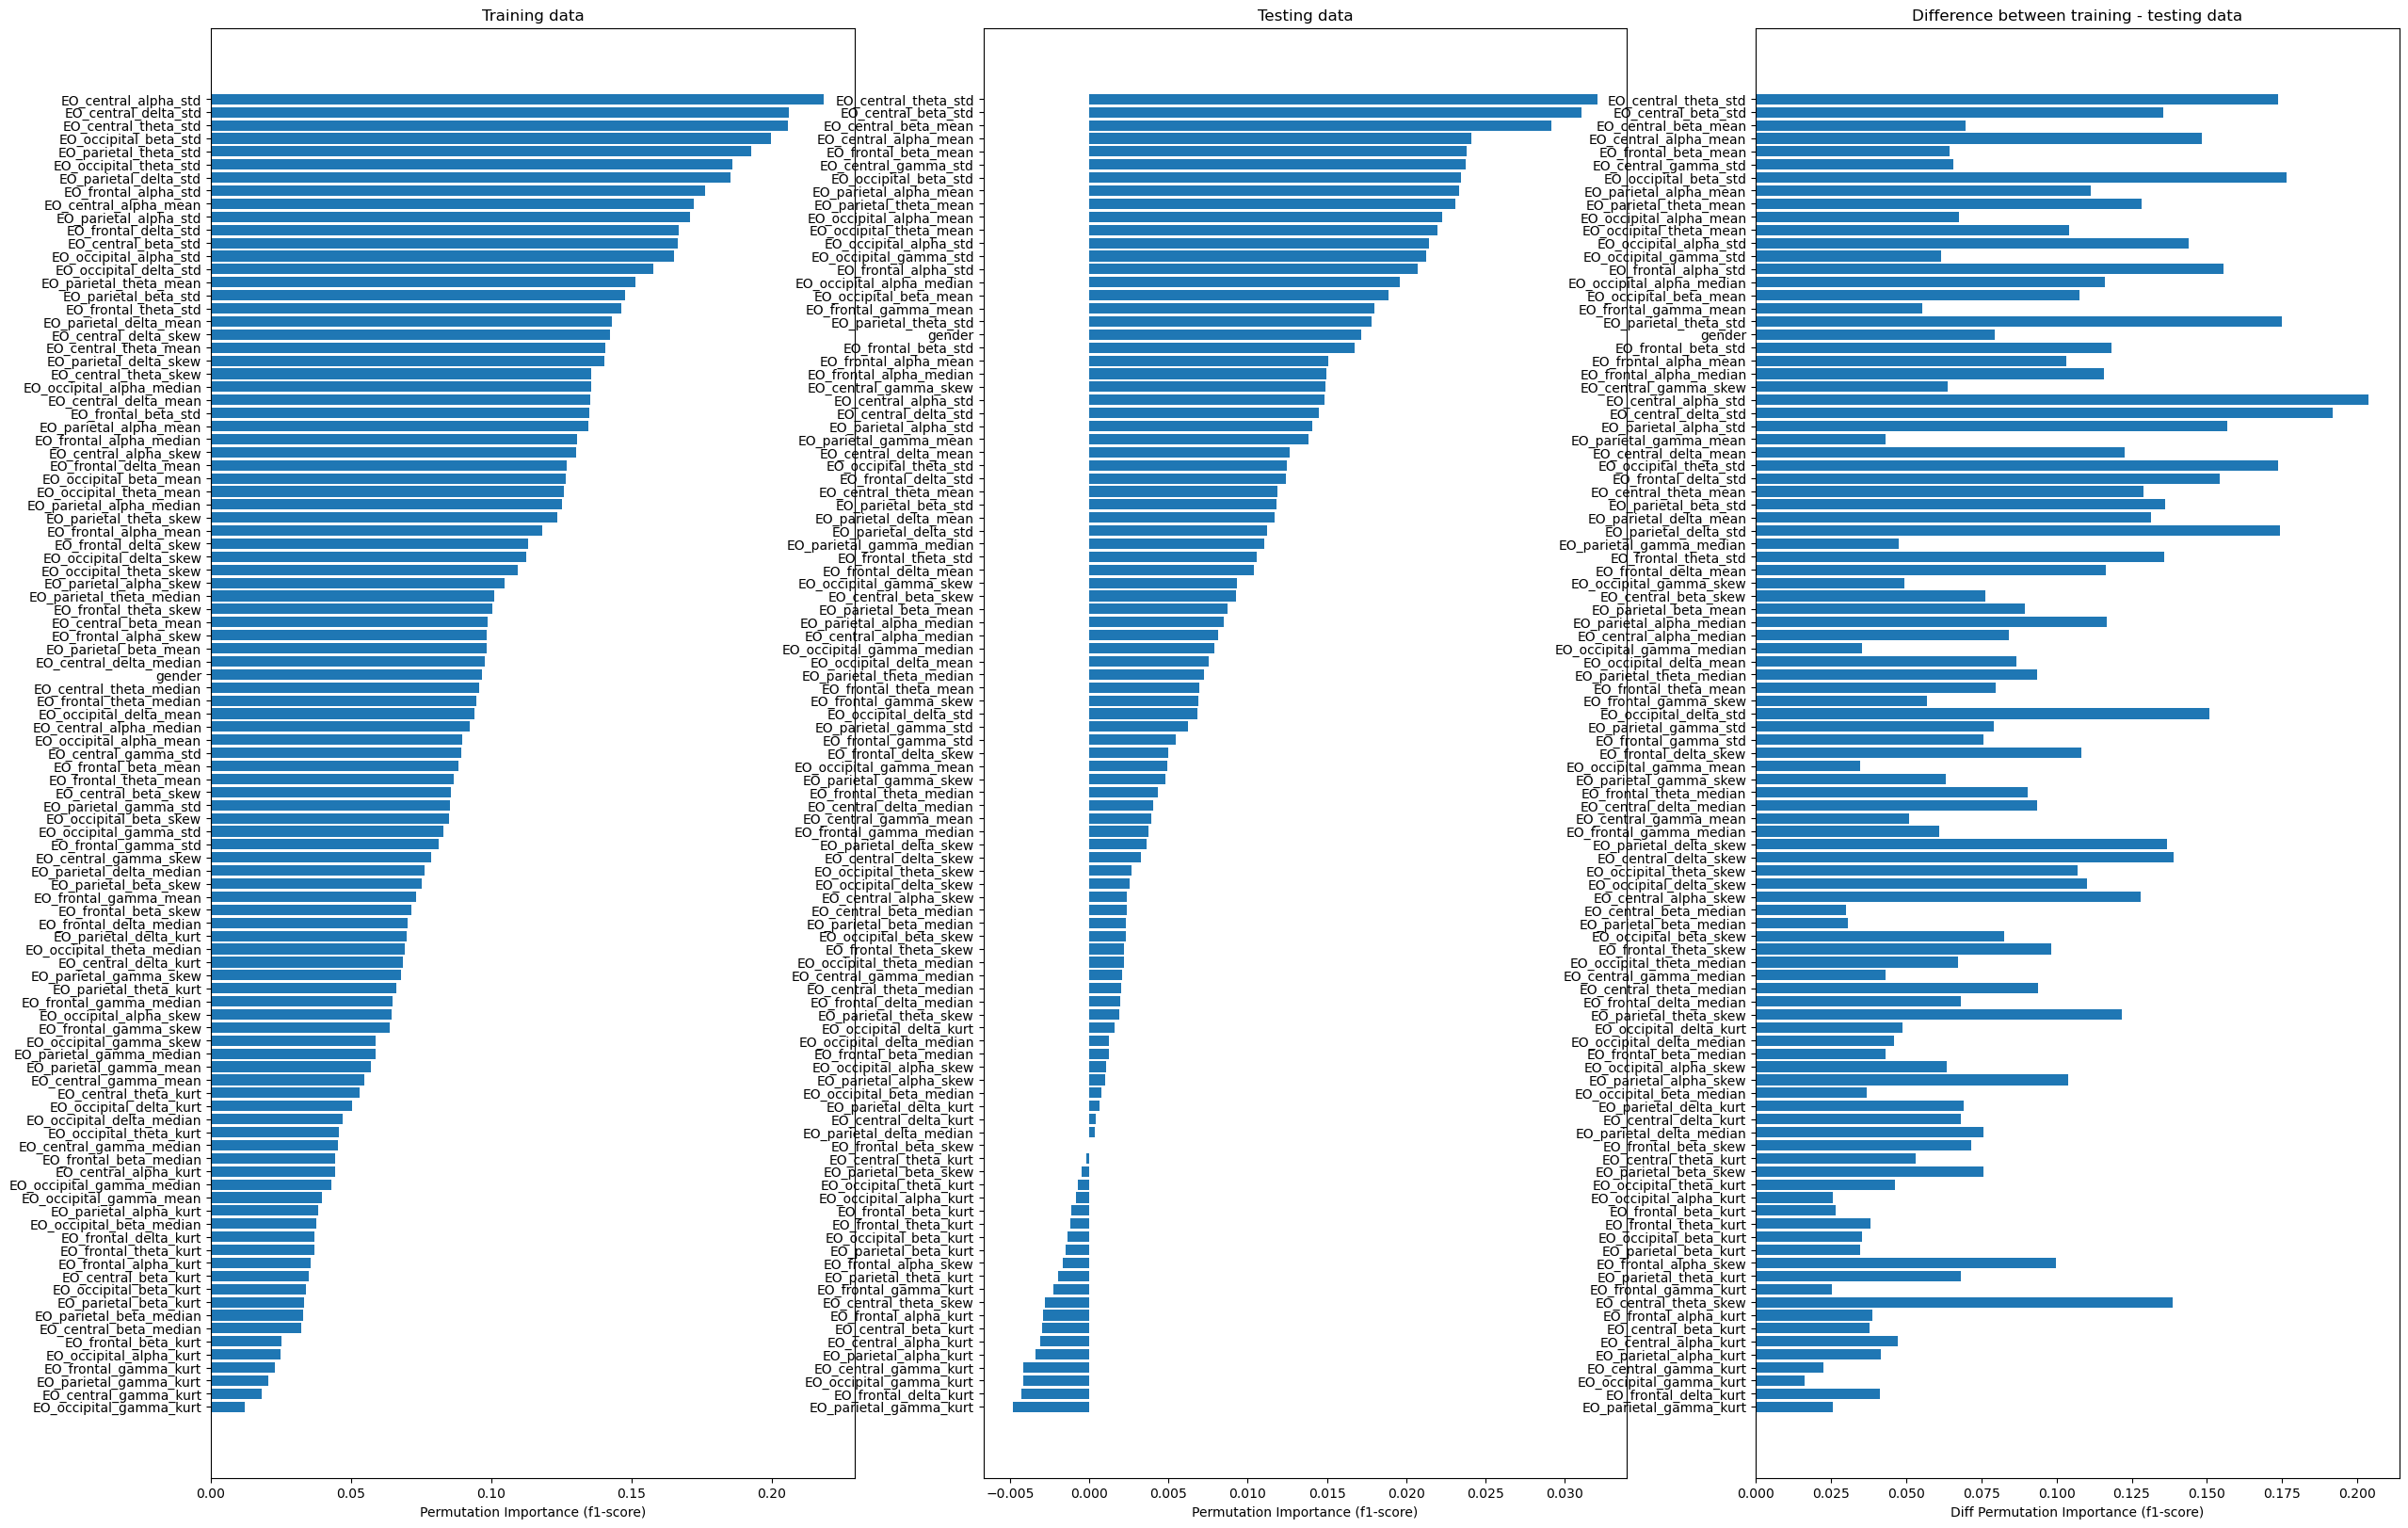

In [12]:
# using permutation_importance()
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

### RF without skew & kurt

#### ratio feature set

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_ratio_nosk['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['ratio']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ratio_nosk[numeric_cols + cat_cols]
Y = df_features_ratio_nosk['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'RF__n_estimators': n_estimators,
               'RF__max_features': max_features,
               'RF__max_depth': max_depth,
               'RF__min_samples_split': min_samples_split,
               'RF__min_samples_leaf': min_samples_leaf,
               'RF__bootstrap': bootstrap}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
rf_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('RF test scores:', rf_test_score)
print('Mean RF test score:', np.mean(rf_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'RF__n_estimators': 200, 'RF__min_samples_split': 10, 'RF__min_samples_leaf': 2, 'RF__max_features': 'sqrt', 'RF__max_depth': 30, 'RF__bootstrap': False}
Best f1-score: 0.3941919747472857


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RF test scores: [0.37570196 0.3746494  0.39346193 0.40342311 0.40894183]
Mean RF test score: 0.3912356455176525


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 66.7min finished


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished


f1_score: 0.39340303760636647

classification report:
               precision    recall  f1-score   support

        ADHD       0.54      0.27      0.36      2051
     HEALTHY       0.00      0.00      0.00       564
         MDD       0.49      0.91      0.64      3732
         OCD       0.00      0.00      0.00       540
         SMC       0.00      0.00      0.00      1032

    accuracy                           0.50      7919
   macro avg       0.21      0.23      0.20      7919
weighted avg       0.37      0.50      0.39      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.0s finished


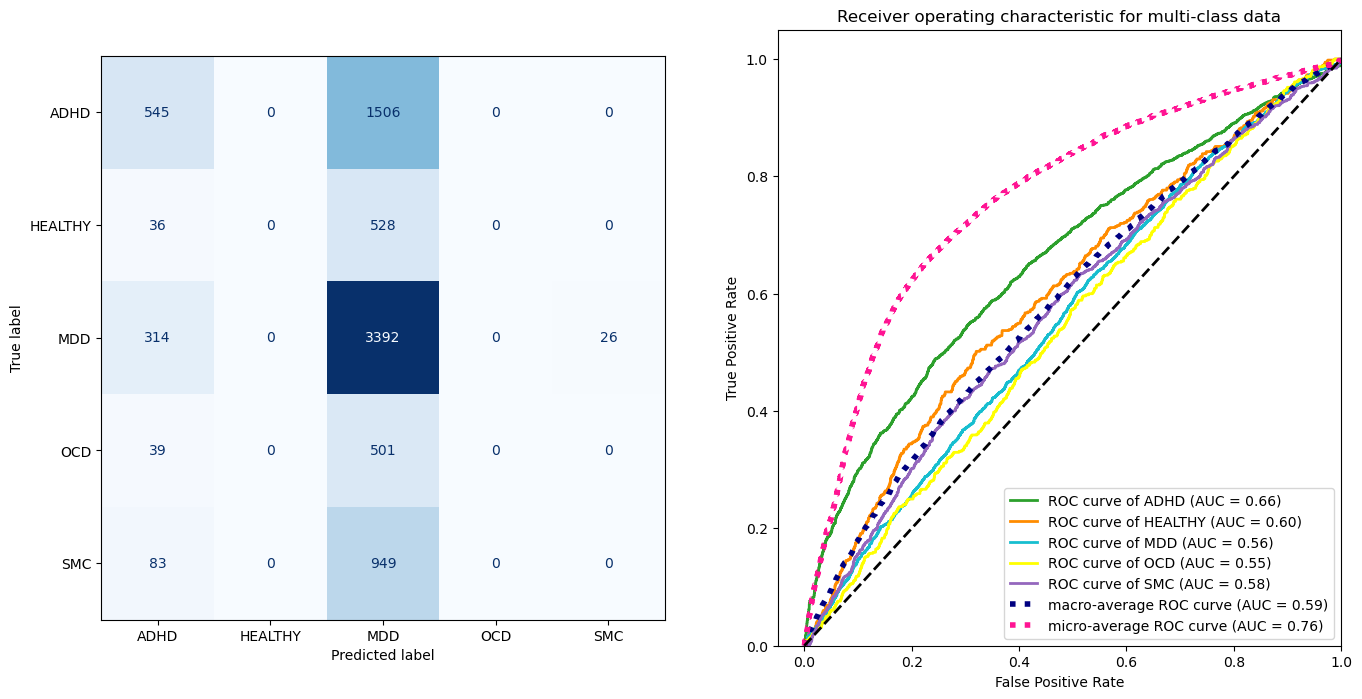

In [14]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[4:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 61), X_test.shape = (1980, 61), Y_train.shape = (5939,), Y_test.shape = (1980,)


Text(0.5, 1.0, 'Difference between training - testing data')

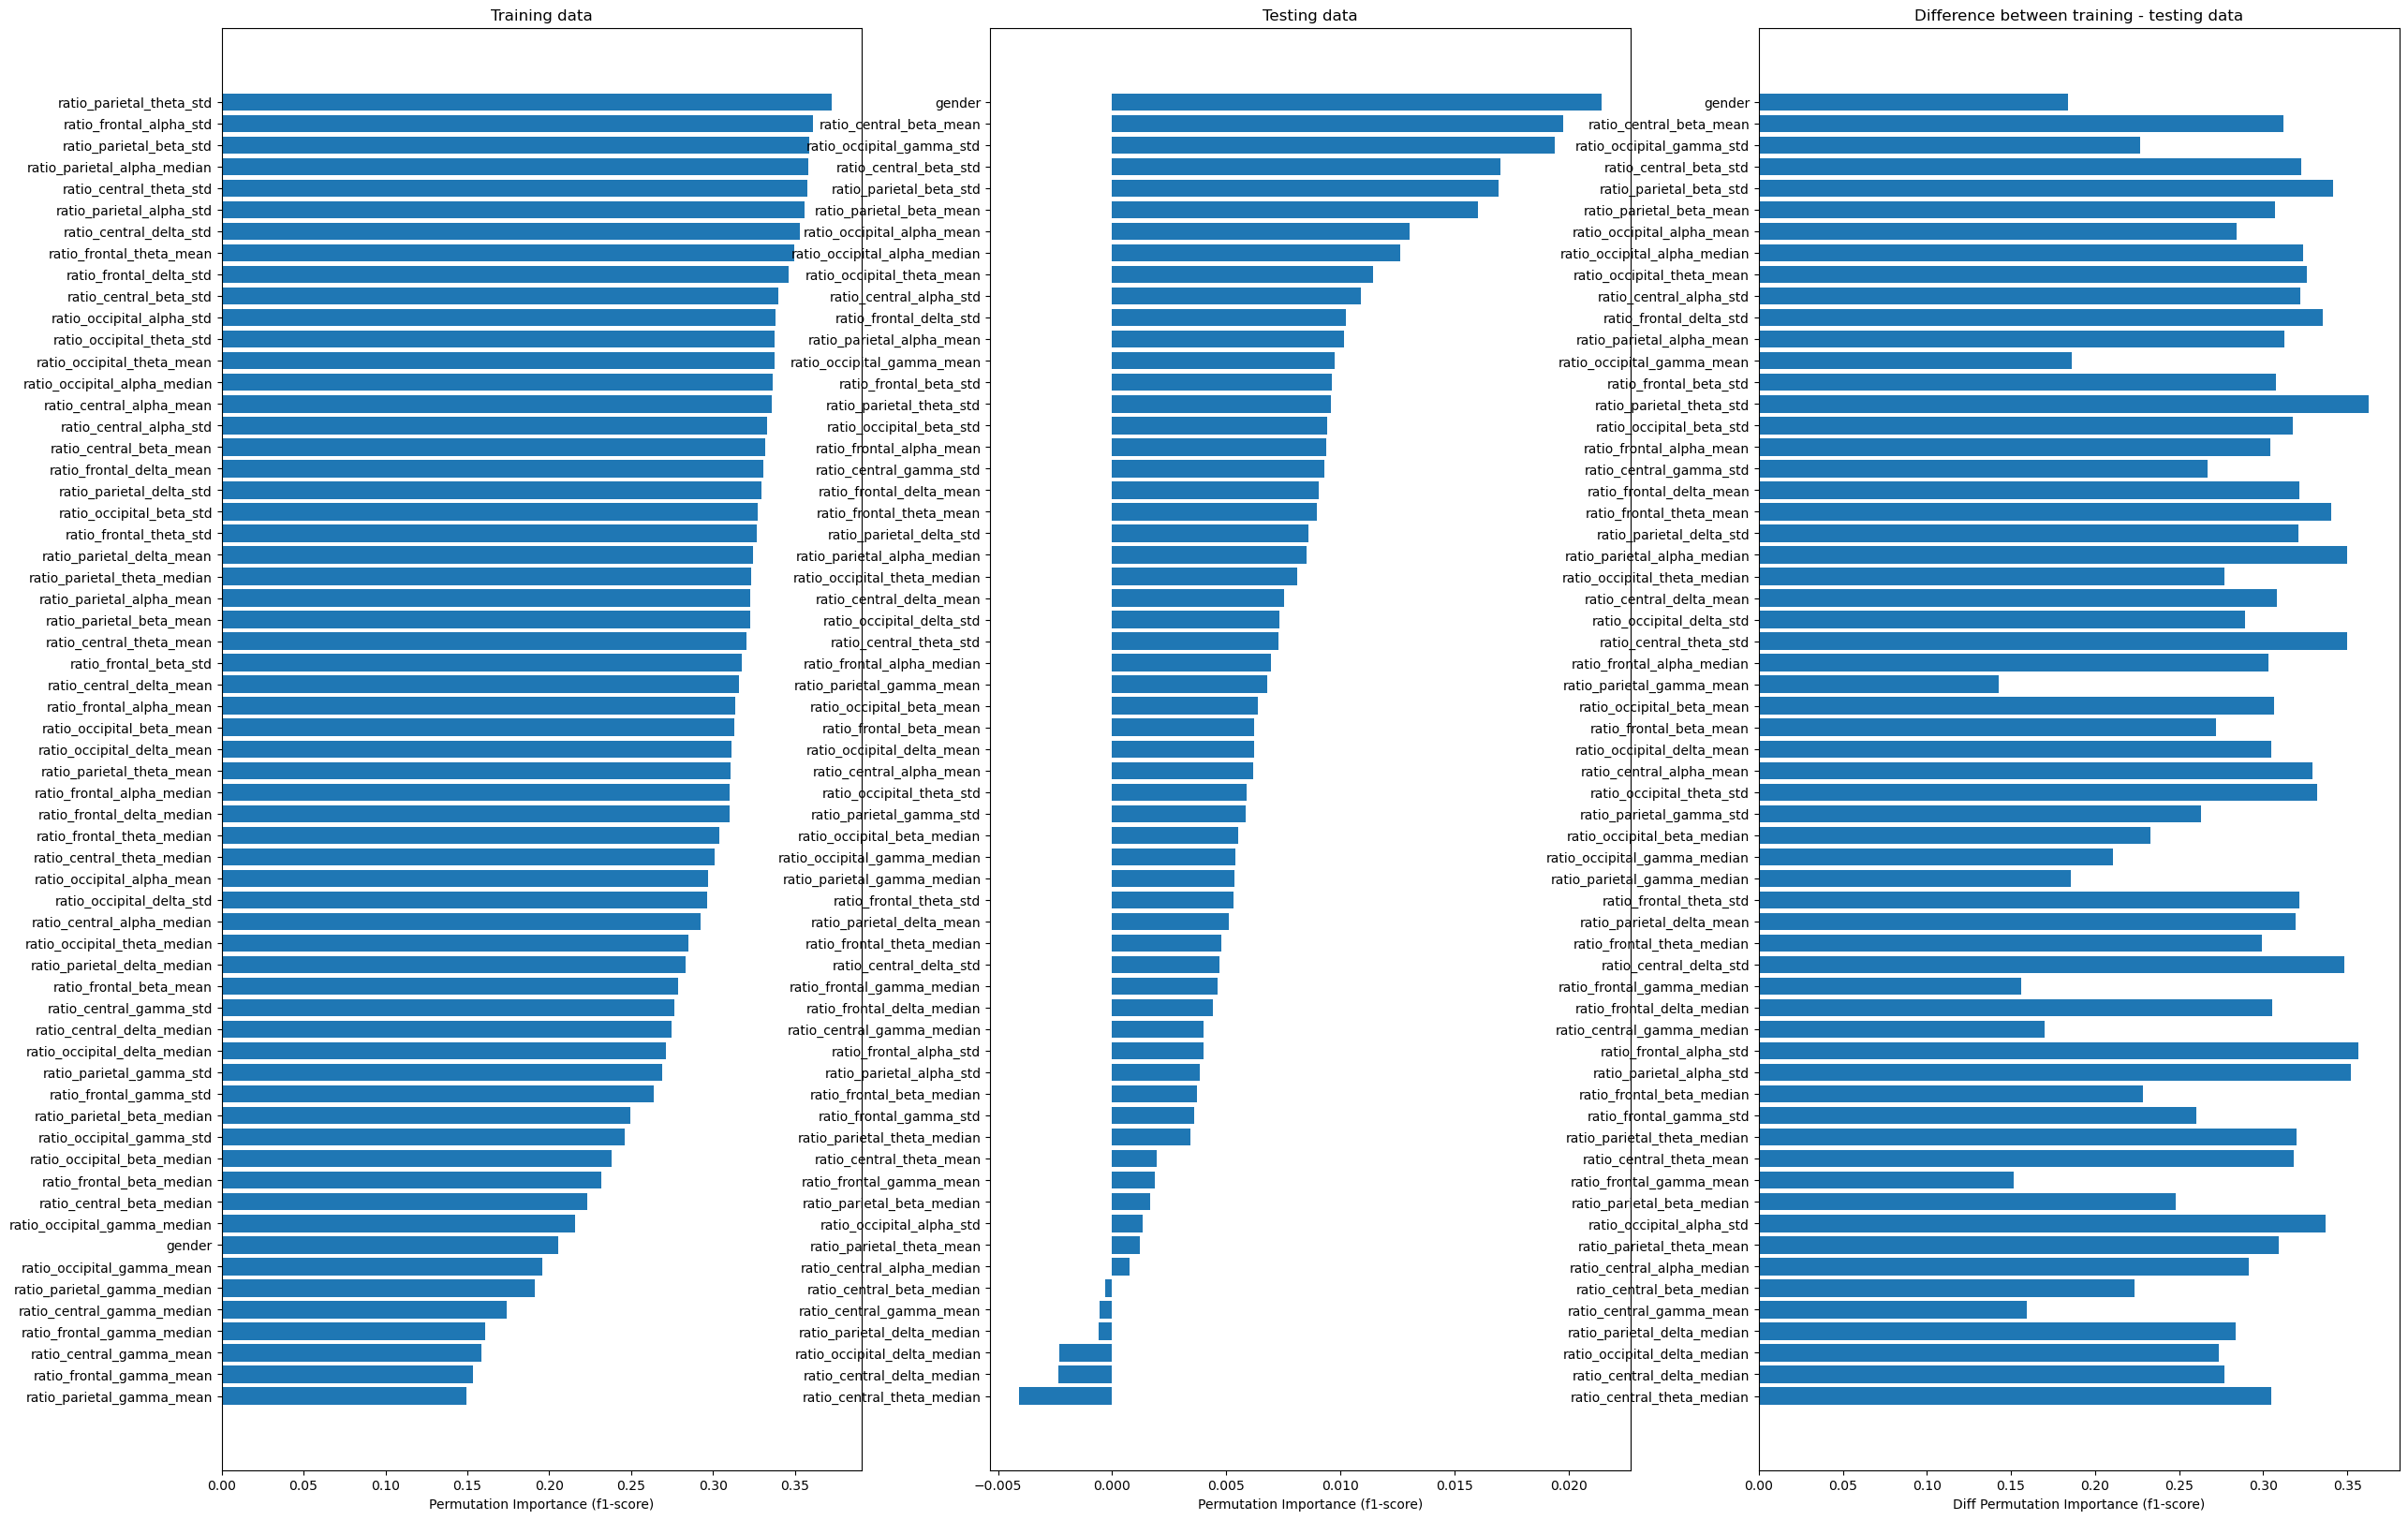

In [15]:
# using permutation_importance()
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EC feature set

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_ec_nosk['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EC']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ec_nosk[numeric_cols + cat_cols]
Y = df_features_ec_nosk['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'RF__n_estimators': n_estimators,
               'RF__max_features': max_features,
               'RF__max_depth': max_depth,
               'RF__min_samples_split': min_samples_split,
               'RF__min_samples_leaf': min_samples_leaf,
               'RF__bootstrap': bootstrap}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
rf_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('RF test scores:', rf_test_score)
print('Mean RF test score:', np.mean(rf_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'RF__n_estimators': 2000, 'RF__min_samples_split': 2, 'RF__min_samples_leaf': 2, 'RF__max_features': 'log2', 'RF__max_depth': 110, 'RF__bootstrap': False}
Best f1-score: 0.41640548445455566


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RF test scores: [0.40470648 0.40941617 0.42446065 0.42206316 0.41738942]
Mean RF test score: 0.41560717804460234


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 64.7min finished


{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 110, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


f1_score: 0.4176649658758854

classification report:
               precision    recall  f1-score   support

        ADHD       0.64      0.31      0.42      2051
     HEALTHY       0.00      0.00      0.00       564
         MDD       0.50      0.93      0.65      3732
         OCD       0.00      0.00      0.00       540
         SMC       0.08      0.00      0.01      1032

    accuracy                           0.52      7919
   macro avg       0.25      0.25      0.22      7919
weighted avg       0.41      0.52      0.42      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


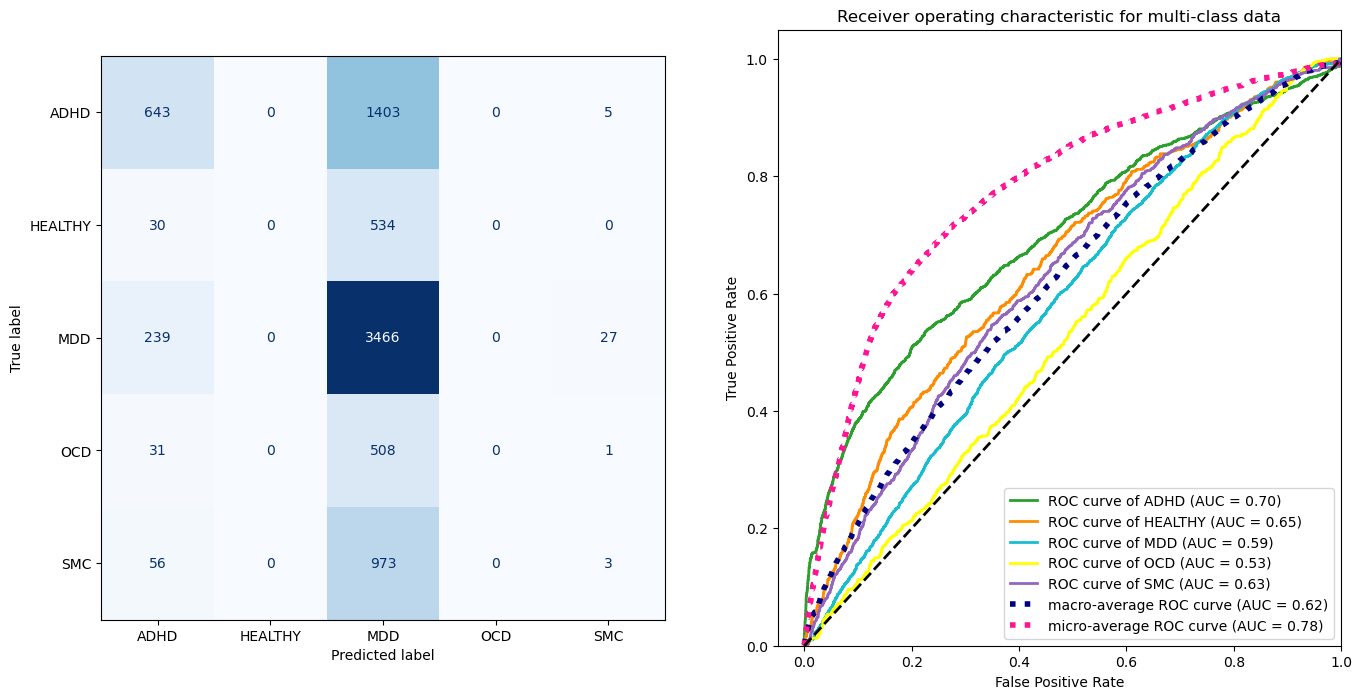

In [17]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[4:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 61), X_test.shape = (1980, 61), Y_train.shape = (5939,), Y_test.shape = (1980,)


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0.5, 1.0, 'Difference between training - testing data')

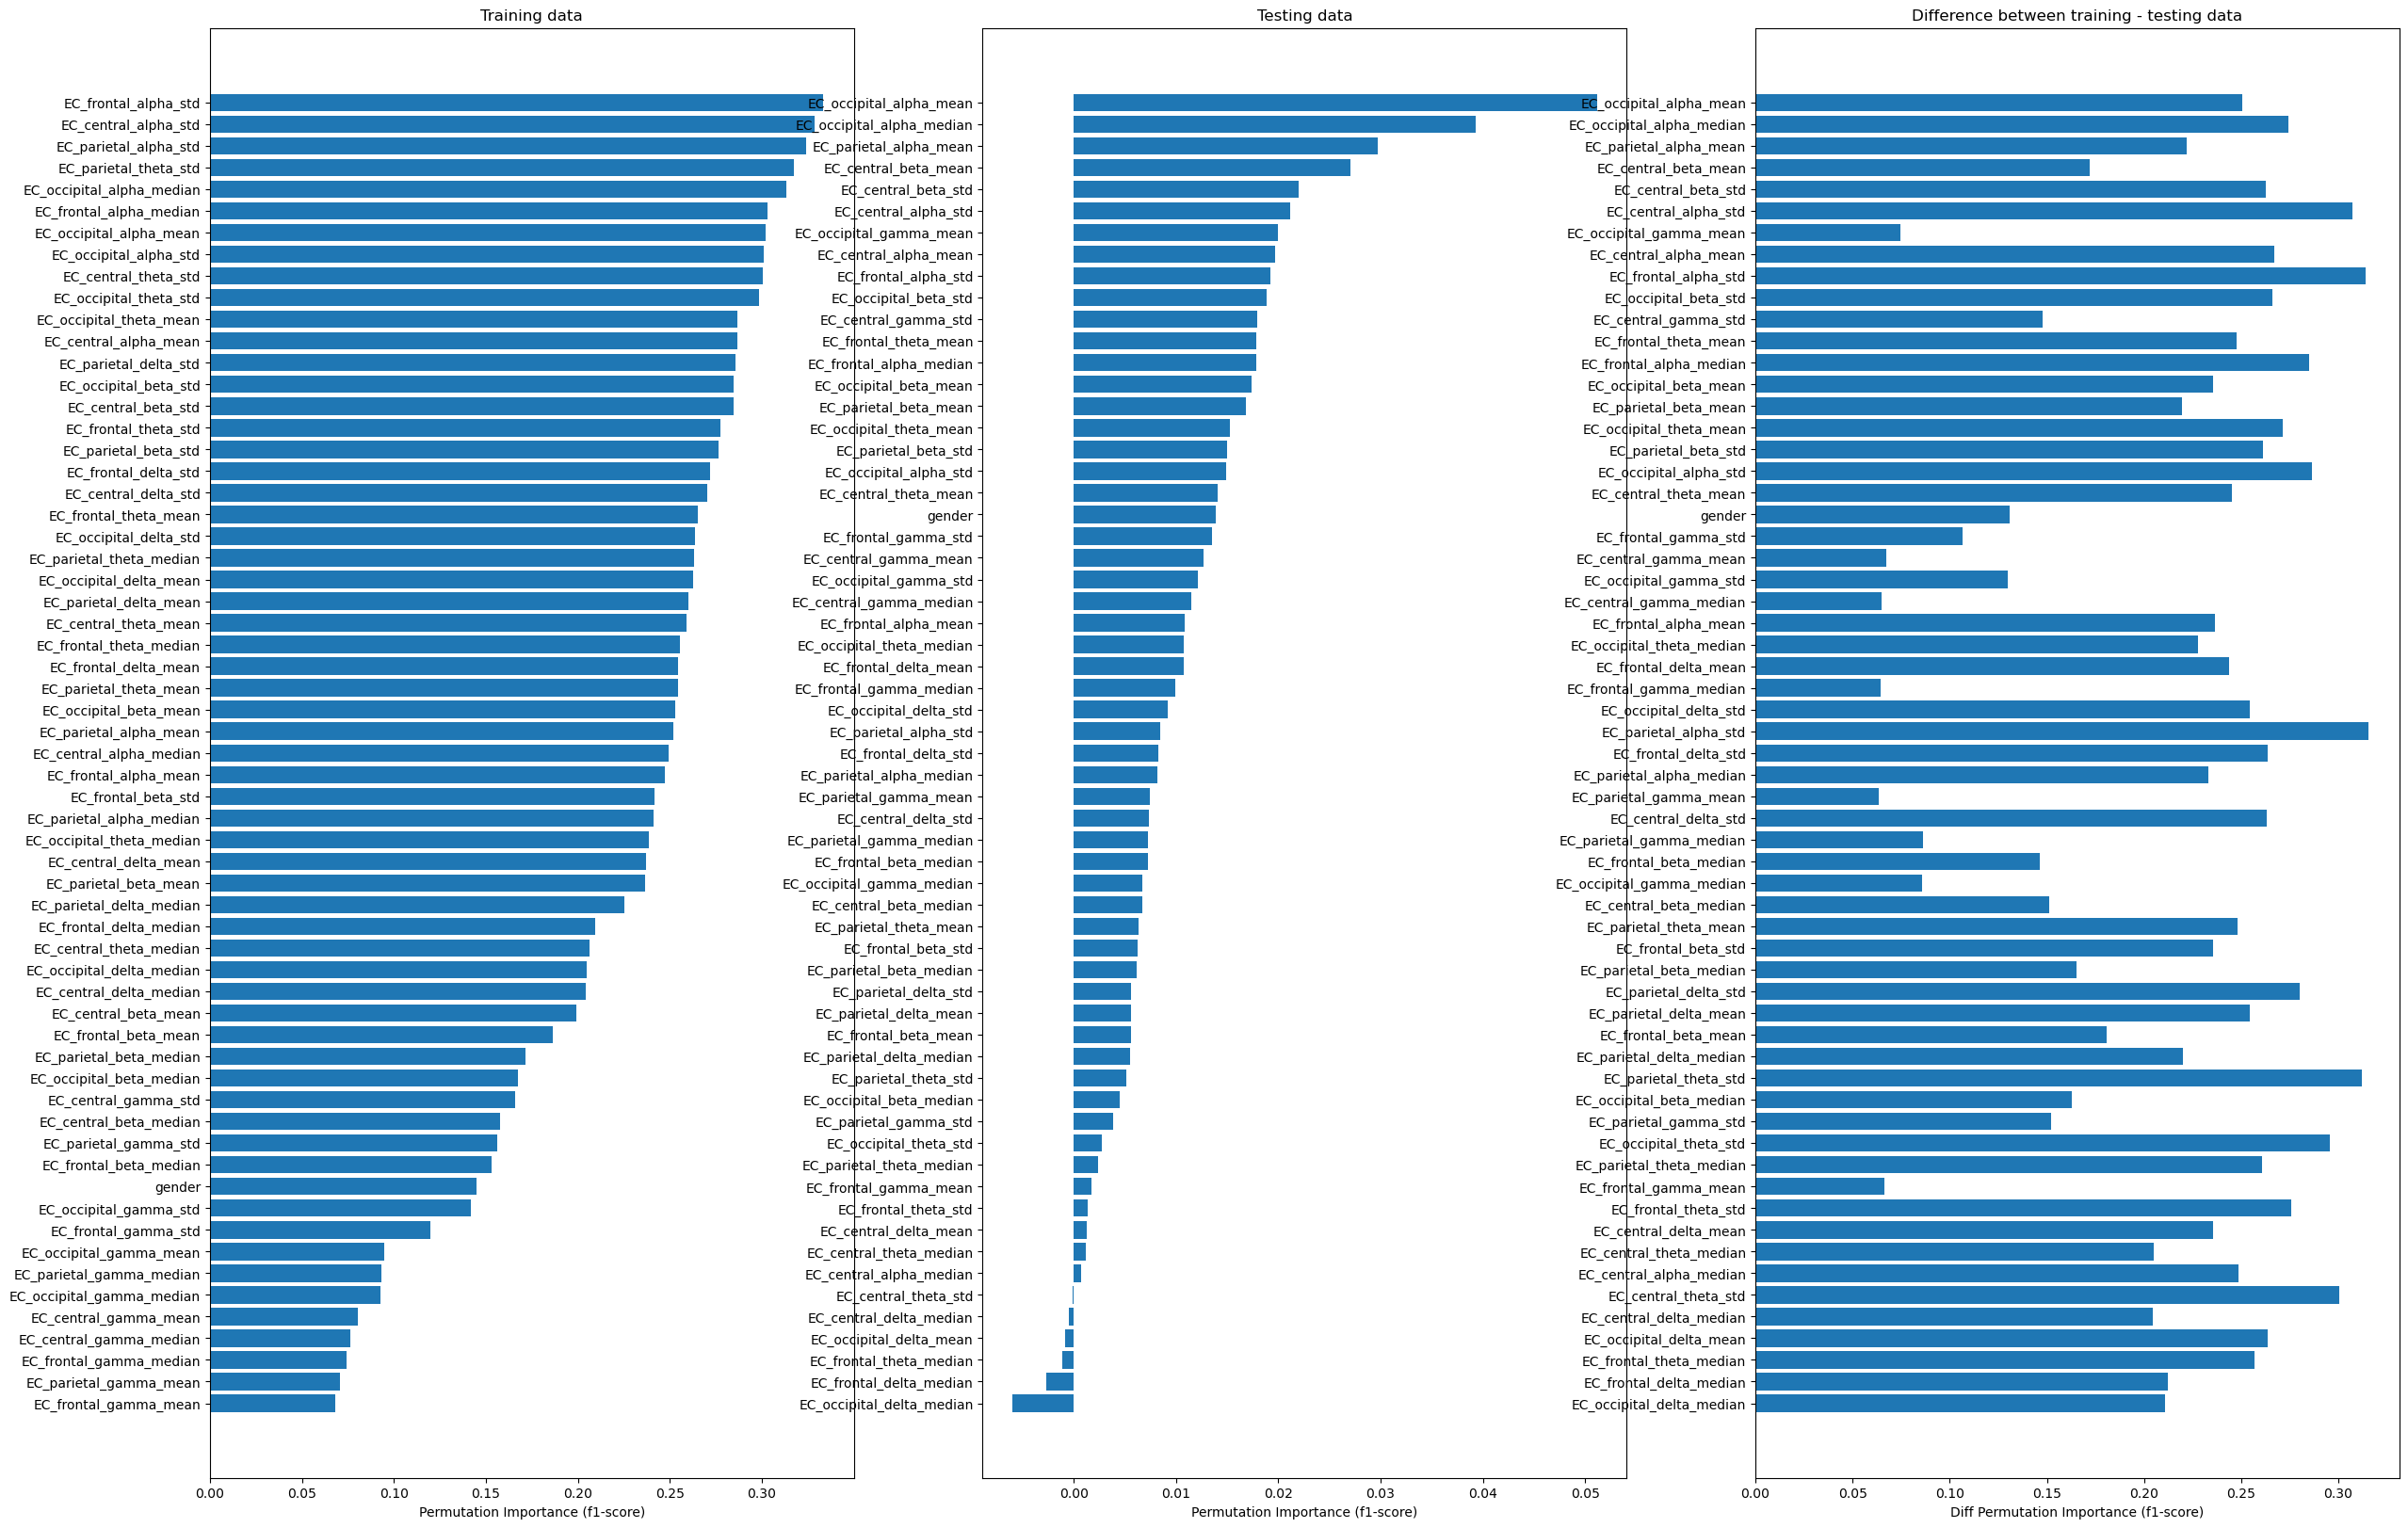

In [18]:
# using permutation_importance()
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EO feature set

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier


# assign groups (IDs) for GroupKFold
groups = df_features_eo_nosk['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_eo_nosk[numeric_cols + cat_cols]
Y = df_features_eo_nosk['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'RF__n_estimators': n_estimators,
               'RF__max_features': max_features,
               'RF__max_depth': max_depth,
               'RF__min_samples_split': min_samples_split,
               'RF__min_samples_leaf': min_samples_leaf,
               'RF__bootstrap': bootstrap}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
rf_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('RF test scores:', rf_test_score)
print('Mean RF test score:', np.mean(rf_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'RF__n_estimators': 1600, 'RF__min_samples_split': 5, 'RF__min_samples_leaf': 1, 'RF__max_features': 'sqrt', 'RF__max_depth': 30, 'RF__bootstrap': False}
Best f1-score: 0.41427127745007936


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RF test scores: [0.36672469 0.4191802  0.41643656 0.4298828  0.44172317]
Mean RF test score: 0.41478948220003653


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 66.8min finished


{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


f1_score: 0.4139008822487834

classification report:
               precision    recall  f1-score   support

        ADHD       0.56      0.32      0.41      2051
     HEALTHY       1.00      0.00      0.00       564
         MDD       0.51      0.91      0.65      3732
         OCD       0.00      0.00      0.00       540
         SMC       0.50      0.00      0.00      1032

    accuracy                           0.51      7919
   macro avg       0.51      0.25      0.21      7919
weighted avg       0.52      0.51      0.41      7919



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


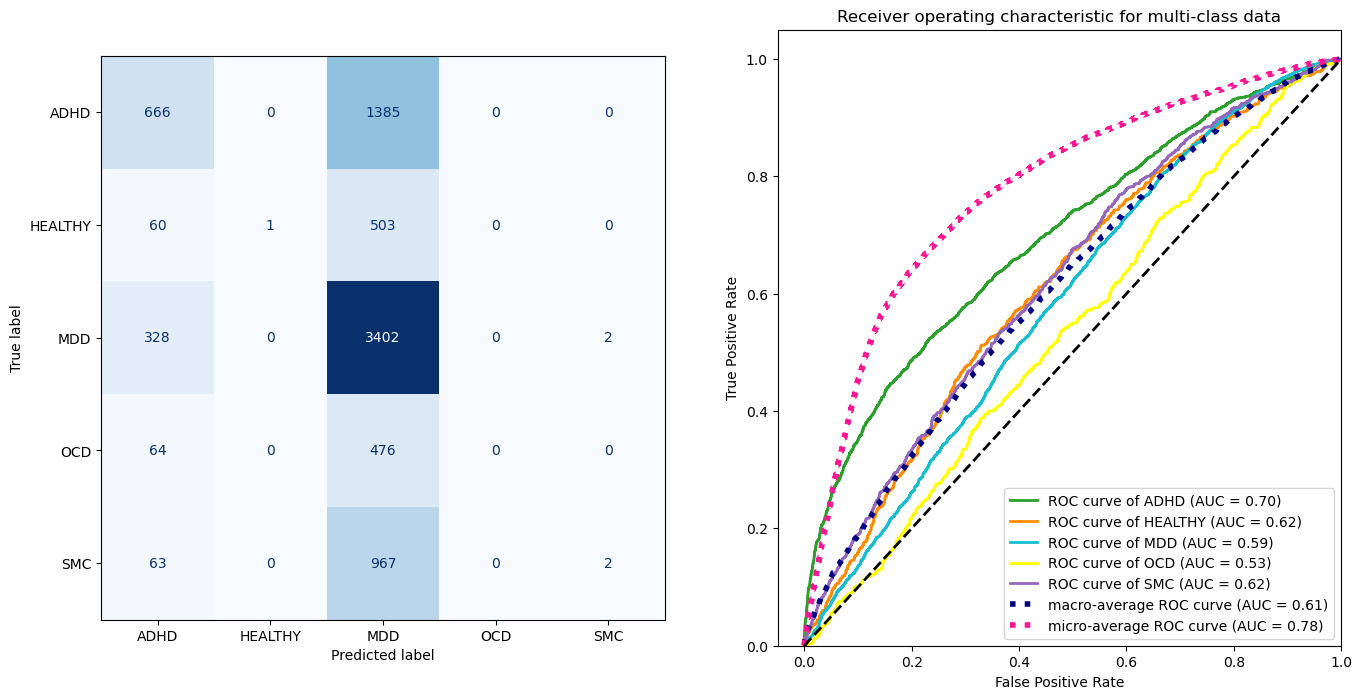

In [20]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[4:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

len(X) = 7919
X_train.shape = (5939, 61), X_test.shape = (1980, 61), Y_train.shape = (5939,), Y_test.shape = (1980,)


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0.5, 1.0, 'Difference between training - testing data')

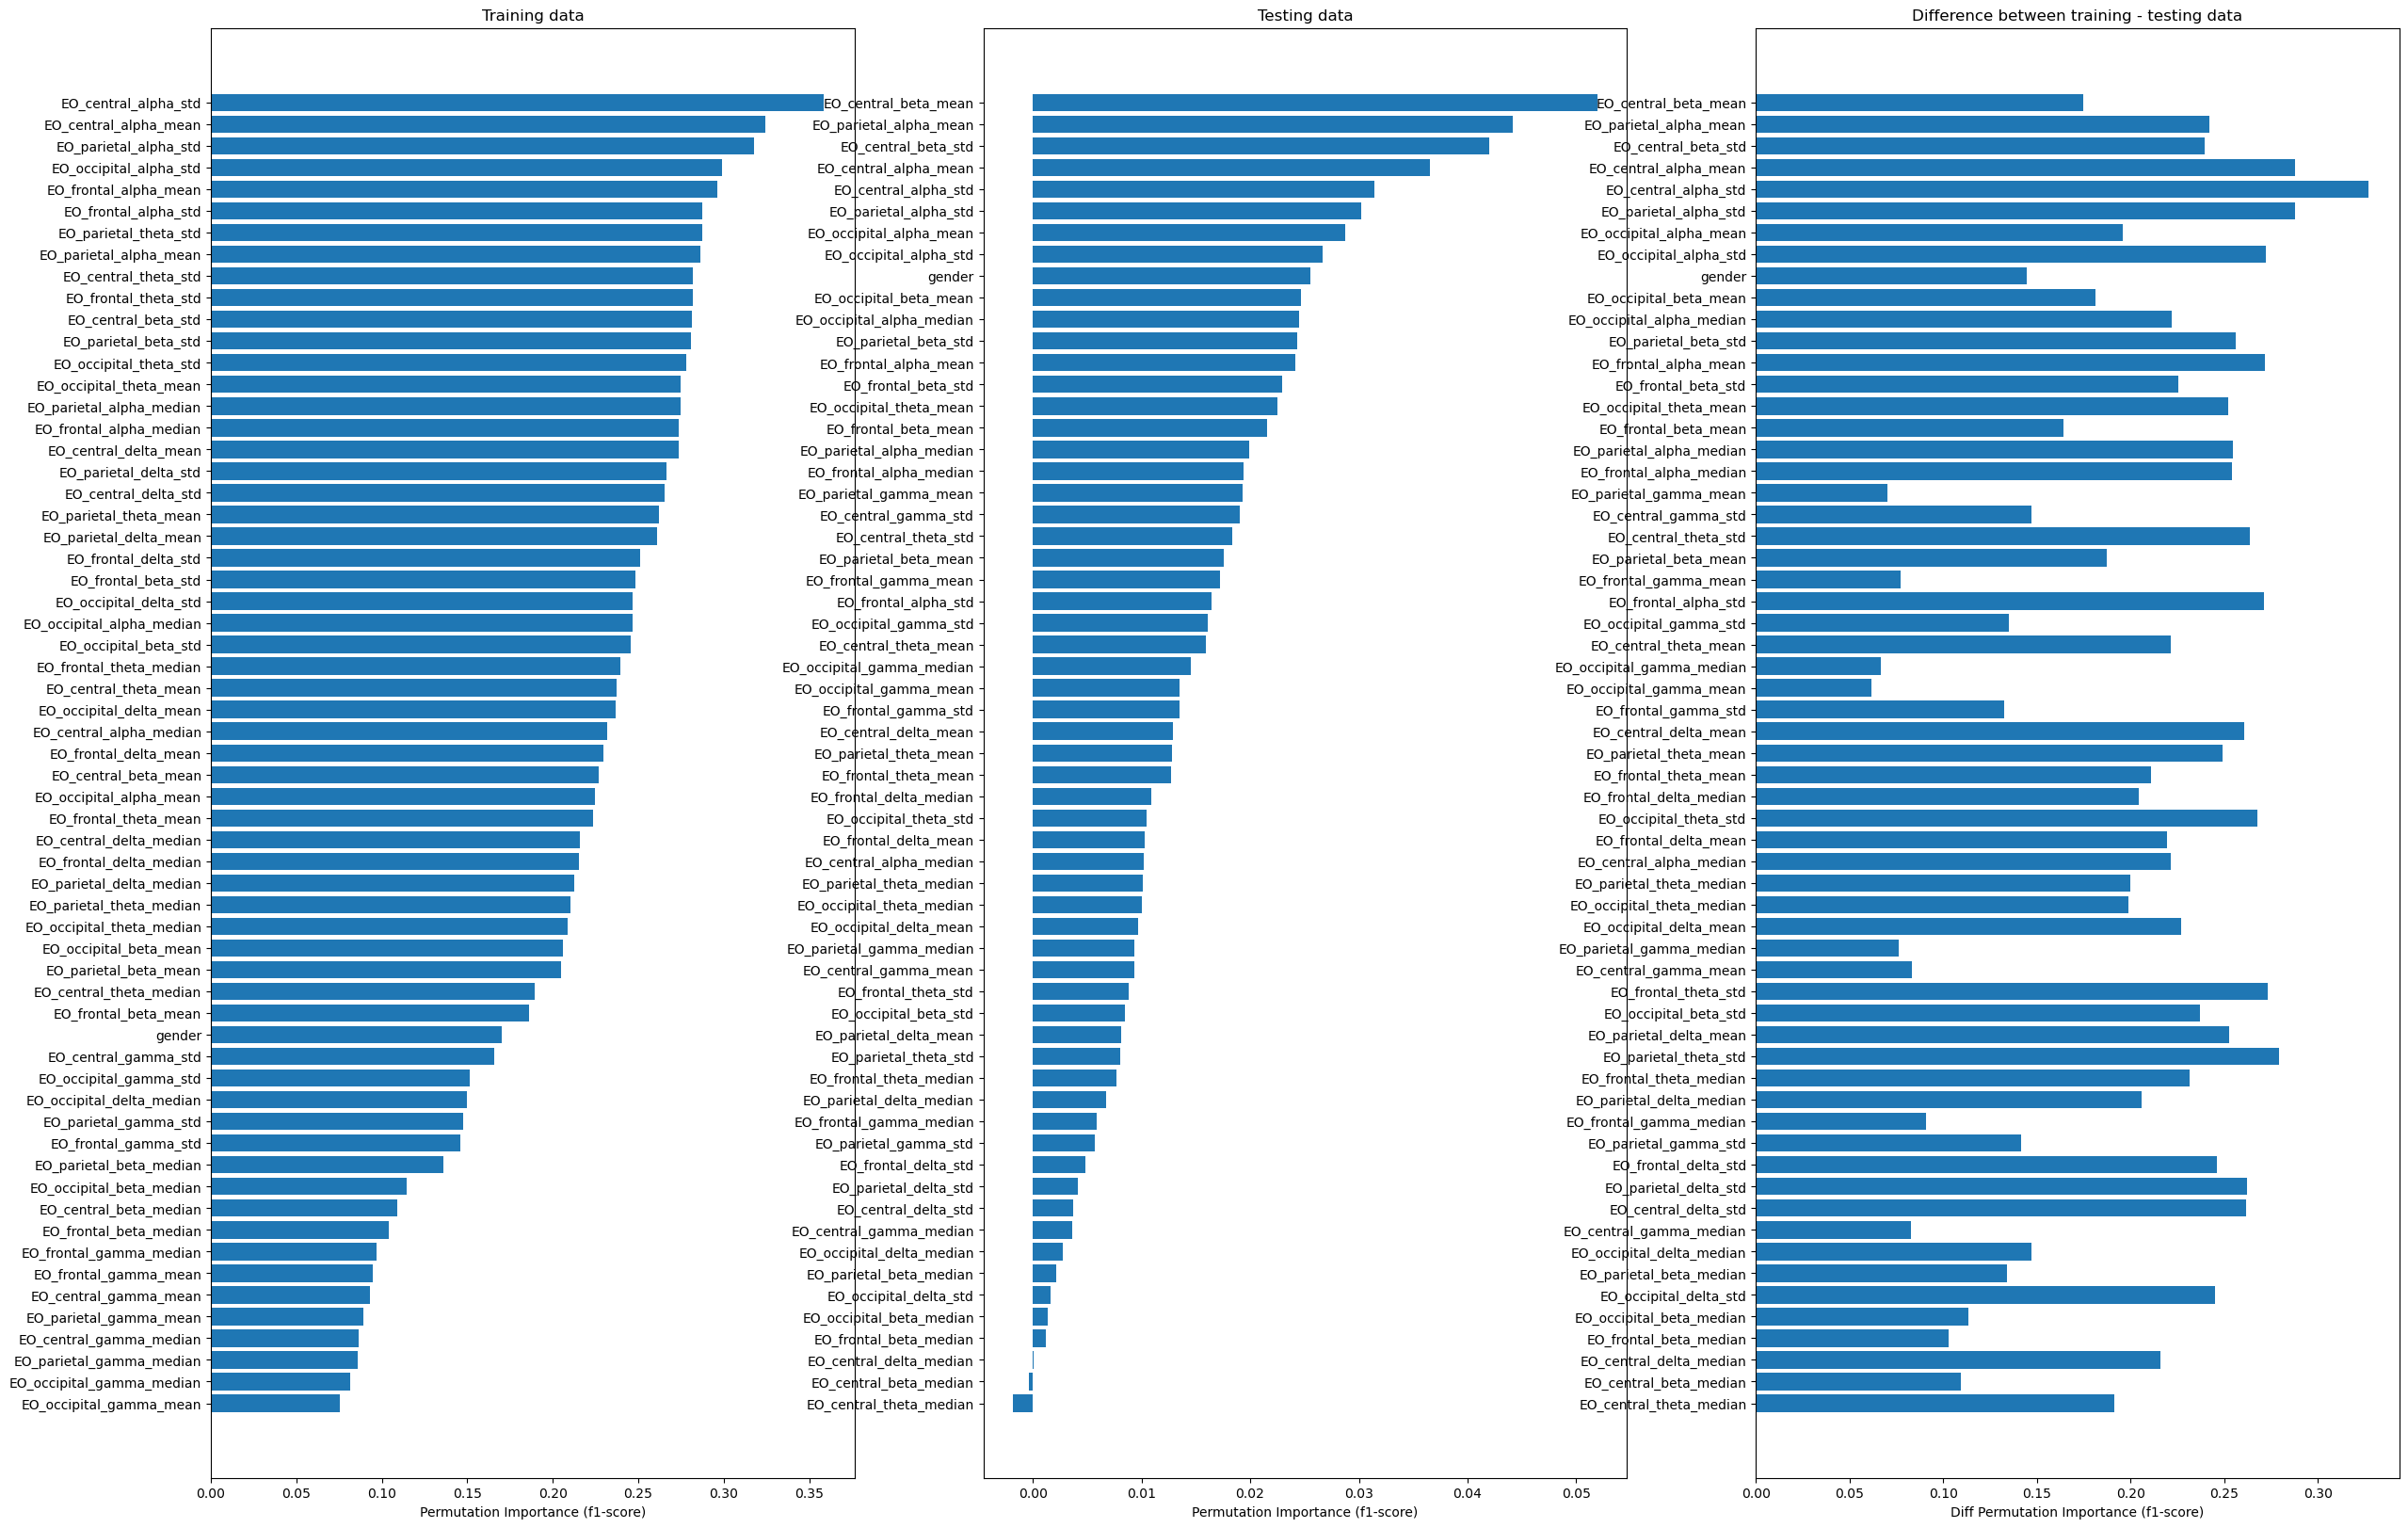

In [21]:
# using permutation_importance()
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

## GradientBoostingClassifier

#### ratio feature set

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import loguniform


# assign groups (IDs) for GroupKFold
groups = df_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['ratio']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ratio[numeric_cols + cat_cols]
Y = df_features_ratio['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)


# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of boosting stages to perform
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Loss function to be optimized
loss = ['log_loss']
# Learning rate
learning_rate = loguniform.rvs(0.001, 0.1, size=1000)
# Fraction of samples to be used for fitting the individual base learners
subsample = [x for x in np.linspace(0.5, 1, 5)]
# The function to measure the quality of the split
criterion = ['friedman_mse']
# The min number of samples required to split an internal node
min_samples_split = [2, 5, 10]
# Create the random grid
random_grid = {'gbc__n_estimators': n_estimators,
               'gbc__loss': loss,
               'gbc__learning_rate': learning_rate,
               'gbc__subsample': subsample,
               'gbc__criterion': criterion,
               'gbc__min_samples_split': min_samples_split}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
gbc_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('GBC test scores:', gbc_test_score)
print('Mean GBC test score:', np.mean(gbc_test_score))


# of instances: 7919
(7919, 5)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'gbc__subsample': 0.5, 'gbc__n_estimators': 700, 'gbc__min_samples_split': 2, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.057927174909156325, 'gbc__criterion': 'friedman_mse'}
Best f1-score: 0.4074418314029797


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  * (last_sum / last_over_new_count - new_sum) ** 2


In [ ]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[5:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

In [ ]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EC feature set

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import loguniform


# assign groups (IDs) for GroupKFold
groups = df_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EC']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ec[numeric_cols + cat_cols]
Y = df_features_ec['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)


# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of boosting stages to perform
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Loss function to be optimized
loss = ['log_loss']
# Learning rate
learning_rate = loguniform.rvs(0.001, 0.1, size=1000)
# Fraction of samples to be used for fitting the individual base learners
subsample = [x for x in np.linspace(0.5, 1, 5)]
# The function to measure the quality of the split
criterion = ['friedman_mse']
# The min number of samples required to split an internal node
min_samples_split = [2, 5, 10]
# Create the random grid
random_grid = {'gbc__n_estimators': n_estimators,
               'gbc__loss': loss,
               'gbc__learning_rate': learning_rate,
               'gbc__subsample': subsample,
               'gbc__criterion': criterion,
               'gbc__min_samples_split': min_samples_split}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
gbc_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('GBC test scores:', gbc_test_score)
print('Mean GBC test score:', np.mean(gbc_test_score))


In [ ]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[5:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

In [ ]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EO feature set

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import loguniform


# assign groups (IDs) for GroupKFold
groups = df_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_eo[numeric_cols + cat_cols]
Y = df_features_eo['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)


# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of boosting stages to perform
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Loss function to be optimized
loss = ['log_loss']
# Learning rate
learning_rate = loguniform.rvs(0.001, 0.1, size=1000)
# Fraction of samples to be used for fitting the individual base learners
subsample = [x for x in np.linspace(0.5, 1, 5)]
# The function to measure the quality of the split
criterion = ['friedman_mse']
# The min number of samples required to split an internal node
min_samples_split = [2, 5, 10]
# Create the random grid
random_grid = {'gbc__n_estimators': n_estimators,
               'gbc__loss': loss,
               'gbc__learning_rate': learning_rate,
               'gbc__subsample': subsample,
               'gbc__criterion': criterion,
               'gbc__min_samples_split': min_samples_split}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
gbc_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('GBC test scores:', gbc_test_score)
print('Mean GBC test score:', np.mean(gbc_test_score))


In [ ]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[5:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

In [ ]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

### GBC without skew & kurt

#### ratio feature set

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import loguniform


# assign groups (IDs) for GroupKFold
groups = df_features_ratio_nosk['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['ratio']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ratio_nosk[numeric_cols + cat_cols]
Y = df_features_ratio_nosk['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)


# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of boosting stages to perform
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Loss function to be optimized
loss = ['log_loss']
# Learning rate
learning_rate = loguniform.rvs(0.001, 0.1, size=1000)
# Fraction of samples to be used for fitting the individual base learners
subsample = [x for x in np.linspace(0.5, 1, 5)]
# The function to measure the quality of the split
criterion = ['friedman_mse']
# The min number of samples required to split an internal node
min_samples_split = [2, 5, 10]
# Create the random grid
random_grid = {'gbc__n_estimators': n_estimators,
               'gbc__loss': loss,
               'gbc__learning_rate': learning_rate,
               'gbc__subsample': subsample,
               'gbc__criterion': criterion,
               'gbc__min_samples_split': min_samples_split}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
gbc_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('GBC test scores:', gbc_test_score)
print('Mean GBC test score:', np.mean(gbc_test_score))


In [ ]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[5:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

In [ ]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EC feature set

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import loguniform


# assign groups (IDs) for GroupKFold
groups = df_features_ec_nosk['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EC']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_ec_nosk[numeric_cols + cat_cols]
Y = df_features_ec_nosk['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)


# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of boosting stages to perform
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Loss function to be optimized
loss = ['log_loss']
# Learning rate
learning_rate = loguniform.rvs(0.001, 0.1, size=1000)
# Fraction of samples to be used for fitting the individual base learners
subsample = [x for x in np.linspace(0.5, 1, 5)]
# The function to measure the quality of the split
criterion = ['friedman_mse']
# The min number of samples required to split an internal node
min_samples_split = [2, 5, 10]
# Create the random grid
random_grid = {'gbc__n_estimators': n_estimators,
               'gbc__loss': loss,
               'gbc__learning_rate': learning_rate,
               'gbc__subsample': subsample,
               'gbc__criterion': criterion,
               'gbc__min_samples_split': min_samples_split}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
gbc_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('GBC test scores:', gbc_test_score)
print('Mean GBC test score:', np.mean(gbc_test_score))


In [ ]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[5:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

In [ ]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')

#### EO feature set

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import loguniform


# assign groups (IDs) for GroupKFold
groups = df_features_eo_nosk['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric & categorical columns
numeric_cols = []
for cond in ['EO']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
cat_cols = ['gender']
 
X = df_features_eo_nosk[numeric_cols + cat_cols]
Y = df_features_eo_nosk['diagnosis']

# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

categoric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')) # most frequent imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ('catergoric_transformer', categoric_transformer, cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)


# final pipeline
steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier())]
pipeline = Pipeline(steps)

# define score metric
f1_scorer = make_scorer(fbeta_score, beta=1, average='weighted')

# define inner & outer CV objects
cv_inner = StratifiedGroupKFold(n_splits = 3, shuffle=False) # shuffle=False, so splits will be the same across calls (?)
cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls (?)

## Hyperparameters for RandomizedSearchCV
# Number of boosting stages to perform
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Loss function to be optimized
loss = ['log_loss']
# Learning rate
learning_rate = loguniform.rvs(0.001, 0.1, size=1000)
# Fraction of samples to be used for fitting the individual base learners
subsample = [x for x in np.linspace(0.5, 1, 5)]
# The function to measure the quality of the split
criterion = ['friedman_mse']
# The min number of samples required to split an internal node
min_samples_split = [2, 5, 10]
# Create the random grid
random_grid = {'gbc__n_estimators': n_estimators,
               'gbc__loss': loss,
               'gbc__learning_rate': learning_rate,
               'gbc__subsample': subsample,
               'gbc__criterion': criterion,
               'gbc__min_samples_split': min_samples_split}

# define randomized search
randsearch = RandomizedSearchCV(pipeline,
                                param_distributions=random_grid,
                                n_iter=100, # 100
                                cv = cv_inner, # use inner cv for hyperparameter tuning
                                scoring = f1_scorer,
                                error_score = 'raise',
                                return_train_score = True,
                                n_jobs=-1,
                                verbose=1)

# non-nested CV for obtaining the propable best hyperparameters
randsearch_fit = randsearch.fit(X, Y, groups = groups)
print(f'Best parameters: {randsearch_fit.best_params_}')
print(f'Best f1-score: {randsearch_fit.best_score_}')

# nested CV with parameter optimization to compute testing score (f1-score)
gbc_test_score = cross_val_score(randsearch, # use unfitted gridsearch object, (idk if this matters)
                                 X = X, y = Y, 
                                 cv = cv_outer, # use outer cv for model evaluation
                                 groups = groups, 
                                 params={"groups": groups},
                                 scoring = f1_scorer,
                                 error_score = 'raise',
                                 verbose=1,
                                 n_jobs=-1)
print('GBC test scores:', gbc_test_score)
print('Mean GBC test score:', np.mean(gbc_test_score))


In [ ]:
# final pipeline
best_params = {}
for hyperparameter in randsearch.best_params_:
    key = hyperparameter[5:]
    best_params[key] = randsearch.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('pca', PCA()), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
class_labels = le.inverse_transform(sorted(np.unique(Y)))
print('f1_score:', f1_score(Y, Y_pred, average = 'weighted', zero_division=0))
print()
print('classification report:\n', classification_report(Y, Y_pred, target_names=class_labels, zero_division=0))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels = class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False, ax=ax1)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

### plot ROC curves
from sklearn.metrics import roc_curve, auc
n_classes = Y_one_hot.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_one_hot[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['tab:green', 'darkorange', 'tab:cyan', 'yellow', 'tab:purple']
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
## Compute macro-average ROC curve and AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)    
## Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_one_hot.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver operating characteristic for multi-class data')
ax2.legend(loc="lower right")
plt.show()

Checking feature importance

In [ ]:
# using permutation_importance(), but according to literature it isn't a very reliable method for SVC with rbf kernel
from sklearn.inspection import permutation_importance

# splitting data into train and test set
desired_test_ratio = 0.25
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)
train_idxs, test_idxs = sgkf.split(X, Y, groups).__next__() # just take the first split
print(f'{len(X) = }')

X_train = X.iloc[train_idxs]
X_test = X.iloc[test_idxs]
Y_train = Y[train_idxs]
Y_test = Y[test_idxs]
print(f'{X_train.shape = }, {X_test.shape = }, {Y_train.shape = }, {Y_test.shape = }')

# fit pipeline to training data
pipeline_fit = pipeline.fit(X_train, Y_train)
train_perm_importance = permutation_importance(pipeline_fit, X_train, Y_train,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

train_sorted_idx = train_perm_importance.importances_mean.argsort()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
ax1.barh(X.columns[train_sorted_idx], train_perm_importance.importances_mean[train_sorted_idx])
ax1.set_xlabel("Permutation Importance (f1-score)")
ax1.set_title('Training data')

# fit pipeline to test data
test_perm_importance = permutation_importance(pipeline_fit, X_test, Y_test,
                                    n_repeats=5, random_state=42,
                                    n_jobs=-1, scoring=f1_scorer)

test_sorted_idx = test_perm_importance.importances_mean.argsort()
ax2.barh(X.columns[test_sorted_idx], test_perm_importance.importances_mean[test_sorted_idx])
ax2.set_xlabel("Permutation Importance (f1-score)")
ax2.set_title('Testing data')

# plot difference between training and testing permutation importance (im not entirely
# sure if the indices are the same for both test/train data, as the importances_mean attribute is just a numpy array)
diff = train_perm_importance.importances_mean - test_perm_importance.importances_mean
ax3.barh(X.columns[test_sorted_idx], diff[test_sorted_idx])
ax3.set_xlabel("Diff Permutation Importance (f1-score)")
ax3.set_title('Difference between training - testing data')